# Paper

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.constants import h, k, atomic_mass, hbar
from scipy.integrate import odeint
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Constants
m = 87 * atomic_mass  # Mass of Rb-87
kb = k  # Boltzmann constant
a_s = 5.77e-9  # Scattering length for Rb-87 (m)
lambda_laser = 1064e-9  # Wavelength of trapping laser (m)

# Simulation parameters
N_initial = 2.7e5  # Initial number of atoms (from paper)
T_initial = 20e-6  # Initial temperature (K), estimate
time_step = 1e-3  # Time step for simulation (s)
total_time = 0.575  # Total simulation time (s), matching paper

# Noise parameters
hardware_noise_level = 0.02
environmental_noise_level = 0.01

# Define the parameter space for optimization
param_space = {
    'P_y': (1e-3, 3),  # Horizontal trap power (W)
    'P_z': (1e-3, 3),  # Vertical trap power (W)
    'P_R': (1e-6, 1e-2),  # Raman coupling power (W)
    'P_p': (1e-6, 1e-2),  # Optical pumping power (W)
    'B_z': (0, 1e-3),  # Magnetic field (T)
    'trap_freq_x': (1, 1e3),  # Trap frequency in x-direction (Hz)
    'trap_freq_y': (1, 1e3),  # Trap frequency in y-direction (Hz)
    'trap_freq_z': (1, 1e3),  # Trap frequency in z-direction (Hz)
    'loading_rate': (0, 1e6)  # Loading rate (atoms/s)
}

def safe_log(x):
    """Safely compute logarithm, avoiding domain errors."""
    return np.log(np.maximum(x, 1e-10))

def trap_potential(r, P_y, P_z, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the trapping potential."""
    w_x = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_x))
    w_y = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_y))
    w_z = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_z))
    
    return 0.5 * m * (
        (2 * np.pi * trap_freq_x)**2 * r[0]**2 +
        (2 * np.pi * trap_freq_y)**2 * r[1]**2 +
        (2 * np.pi * trap_freq_z)**2 * r[2]**2
    )

def raman_cooling_rate(v, P_R, P_p, B_z):
    """Calculate the Raman cooling rate."""
    v_r = hbar * 2 * np.pi / (m * lambda_laser)
    gamma_r = 2 * np.pi * 6.065e6
    delta = 2 * np.pi * 4.33e9
    
    return gamma_r * (P_R + P_p) / (1 + (2 * v / v_r)**2 + (2 * delta / gamma_r)**2) * np.exp(-v**2 / v_r**2)

def collision_rate(n, T):
    """Calculate the collision rate."""
    sigma = 8 * np.pi * a_s**2
    v_rms = np.sqrt(3 * kb * T / m)
    return n * sigma * v_rms

def bec_fraction(N, T, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the BEC fraction."""
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    T_c = 0.94 * hbar * omega_bar * (N / zeta(3))**(1/3) / kb
    return max(0, 1 - (T / T_c)**3) if T < T_c else 0

def zeta(x):
    """Riemann zeta function."""
    return np.sum(1 / np.arange(1, 1000)**x)

def system_dynamics(y, t, params):
    N, T = y
    P_y, P_z, P_R, P_p, B_z, trap_freq_x, trap_freq_y, trap_freq_z, loading_rate = params
    
    # Ensure positive values
    N = max(N, 1e-10)
    T = max(T, 1e-10)
    
    # Calculate trap properties
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
    n = N / V_eff
    
    # Calculate rates
    gamma_col = collision_rate(n, T)
    gamma_cool = raman_cooling_rate(np.sqrt(3 * kb * T / m), P_R, P_p, B_z)
    gamma_heat = 1e-3 * (P_y + P_z)
    gamma_loss = 1e-2 * np.exp(-safe_log(P_y + P_z) + safe_log(kb * T))
    
    # System dynamics
    dNdt = loading_rate - gamma_loss * N
    dTdt = gamma_heat - gamma_cool * T + (gamma_col / 3) * (hbar * omega_bar / kb - T)
    
    return [dNdt, dTdt]

def simulate_bec(params, t):
    try:
        # Add hardware noise
        params_with_noise = [max(p * (1 + np.random.normal(0, hardware_noise_level)), 1e-10) for p in params]
        
        # Solve ODE
        y0 = [N_initial, T_initial]
        solution = odeint(system_dynamics, y0, [0, t], args=(params_with_noise,))
        
        N, T = solution[-1]
        
        # Add environmental noise
        N = max(N * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        T = max(T * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        
        # Calculate phase space density
        omega_bar = (params[5] * params[6] * params[7])**(1/3) * 2 * np.pi
        V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
        n = N / V_eff
        lambda_dB = h / np.sqrt(2 * np.pi * m * kb * T)
        PSD = n * lambda_dB**3
        
        # Calculate BEC fraction
        f_bec = bec_fraction(N, T, params[5], params[6], params[7])
        
        return N, T, PSD, f_bec
    except Exception as e:
        print(f"Error in simulate_bec: {e}")
        return 1e-10, 1e-10, 1e-10, 0

def objective_function(params):
    try:
        N, T, PSD, f_bec = simulate_bec(params, total_time)
        
        # Calculate optical depth (simplified model)
        OD = N**(2/5) / T
        
        # Cost function (to be minimized)
        alpha = 0.5
        cost = -(OD**3 * N**(alpha - 9/5))
        
        return cost if np.isfinite(cost) else 1e10
    except Exception as e:
        print(f"Error in objective_function: {e}")
        return 1e10

def generate_od_image(N, T, f_bec, trap_freq_x, trap_freq_y, trap_freq_z, image_size=128, tof=0.025):
    """Generate a simulated optical density (OD) image of the BEC and thermal cloud."""
    N_bec = N * f_bec
    N_thermal = N - N_bec
    
    # Calculate cloud sizes after time of flight
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    R_tf = (15 * N_bec * a_s * hbar**2 / (m**2 * omega_bar**2))**(1/5)  # Thomas-Fermi radius
    sigma_thermal = np.sqrt(kb * T / (m * omega_bar**2))
    
    x = np.linspace(-3*R_tf, 3*R_tf, image_size)
    y = np.linspace(-3*R_tf, 3*R_tf, image_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    # BEC component (Thomas-Fermi profile)
    od_bec = np.maximum(0, (1 - (R / R_tf)**2))**(3/2)
    od_bec *= N_bec / np.sum(od_bec)  # Normalize
    
    # Thermal component (Gaussian profile)
    od_thermal = np.exp(-(X**2 + Y**2) / (2 * sigma_thermal**2))
    od_thermal *= N_thermal / np.sum(od_thermal)  # Normalize
    
    # Combine BEC and thermal components
    od_total = od_bec + od_thermal
    
    return od_total

def bayesian_optimization(n_iterations=100, n_images=5):
    
    def obj_wrapper(x):
        return objective_function(x.flatten())
    
    bounds = np.array(list(param_space.values()))
    n_params = len(bounds)
    
    kernel = C(1.0, (1e-3, 1e3)) * RBF(np.ones(n_params), (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(10, n_params))
    y_sample = np.array([obj_wrapper(x) for x in X_sample])
    
    best_params = X_sample[np.argmin(y_sample)]
    best_images = []
    best_N_list = []
    best_T_list = []
    best_PSD_list = []
    best_f_bec_list = []
    
    # New lists to store optimization progress
    all_costs = []
    all_N = []
    all_T = []
    all_f_bec = []
    
    # Calculate image indices
    if n_images == 5:
        image_indices = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1]
    else:  # n_images == 3
        image_indices = [n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4]
    
    for i in range(n_iterations):
        print("Running " + str(i) + "th iterations of Bayesian optimization...")
        try:
            gp.fit(X_sample, y_sample)
            
            def acquisition(x):
                mean, std = gp.predict(x.reshape(1, -1), return_std=True)
                return mean - 1.96 * std
            
            result = minimize(acquisition, X_sample[np.argmin(y_sample)], method='L-BFGS-B', bounds=bounds)
            
            if result.success:
                X_next = result.x
            else:
                X_next = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(1, n_params))
            
            y_next = obj_wrapper(X_next)
            
            X_sample = np.vstack((X_sample, X_next))
            y_sample = np.append(y_sample, y_next)
            
            # Store the best cost and parameters for this iteration
            best_cost = np.min(y_sample)
            best_params = X_sample[np.argmin(y_sample)]
            
            # Simulate BEC with best parameters and store results
            N, T, PSD, f_bec = simulate_bec(best_params, total_time)
            all_costs.append(-best_cost)  # Negate cost for maximization plot
            all_N.append(N)
            all_T.append(T)
            all_f_bec.append(f_bec)
            
            if i in image_indices:
                od_image = generate_od_image(N, T, f_bec, best_params[5], best_params[6], best_params[7])
                best_images.append(od_image)
                best_N_list.append(N)
                best_T_list.append(T)
                best_PSD_list.append(PSD)
                best_f_bec_list.append(f_bec)
        
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue
    
    return best_params, best_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec

def plot_optimization_performance(all_costs, all_N, all_T, all_f_bec):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    iterations = range(1, len(all_costs) + 1)
    
    axs[0, 0].plot(iterations, all_costs)
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].set_ylabel('Objective Function (maximization)')
    axs[0, 0].set_title('Optimization Progress')
    
    axs[0, 1].semilogy(iterations, all_N)
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].set_ylabel('Atom Number')
    axs[0, 1].set_title('Atom Number Evolution')
    
    axs[1, 0].semilogy(iterations, all_T)
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].set_ylabel('Temperature (K)')
    axs[1, 0].set_title('Temperature Evolution')
    axs[1, 1].plot(iterations, all_f_bec)
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('BEC Fraction')
    axs[1, 1].set_title('BEC Fraction Evolution')
    
    plt.tight_layout()
    plt.show()

def plot_optimization_images(images, N_list, T_list, PSD_list, f_bec_list, n_iterations):
    n_images = len(images)
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.ravel()
    
    for i, (image, N, T, PSD, f_bec) in enumerate(zip(images, N_list, T_list, PSD_list, f_bec_list)):
        if i < n_images:
            im = axs[i].imshow(image, cmap='jet', extent=[-128, 128, -128, 128])
            if n_images == 5:
                iteration = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1][i]
            else:  # n_images == 3
                iteration = [n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4][i]
            axs[i].set_title(f"Iteration {iteration}")
            axs[i].set_xlabel('Position (μm)')
            axs[i].set_ylabel('Position (μm)')
            plt.colorbar(im, ax=axs[i], label='Optical Density')
            
            # Add text with N, T, PSD, and f_bec values
            axs[i].text(0.05, 0.95, f"N: {N:.2e}\nT: {T:.2e} K\nPSD: {PSD:.2e}\nBEC: {f_bec:.2%}", 
                        transform=axs[i].transAxes, verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Remove unused subplots
    for i in range(n_images, 6):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

def run_simulation(optimized_params):
    time_points = np.arange(0, total_time + time_step, time_step)
    N_values = []
    T_values = []
    PSD_values = []
    f_bec_values = []
    
    for t in time_points:
        N, T, PSD, f_bec = simulate_bec(optimized_params, t)
        N_values.append(N)
        T_values.append(T)
        PSD_values.append(PSD)
        f_bec_values.append(f_bec)
    
    return time_points, N_values, T_values, PSD_values, f_bec_values

def plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    
    axs[0, 0].semilogy(time_points * 1e3, N_values)
    axs[0, 0].set_ylabel('Atom Number')
    axs[0, 0].set_title('BEC Formation Dynamics')
    
    axs[1, 0].semilogy(time_points * 1e3, T_values)
    axs[1, 0].set_ylabel('Temperature (K)')
    
    axs[2, 0].semilogy(time_points * 1e3, PSD_values)
    axs[2, 0].set_ylabel('Phase Space Density')
    axs[2, 0].set_xlabel('Time (ms)')
    
    axs[0, 1].plot(time_points * 1e3, f_bec_values)
    axs[0, 1].set_ylabel('BEC Fraction')
    axs[0, 1].set_xlabel('Time (ms)')
    
    # Generate and plot final OD image
    N_final, T_final = N_values[-1], T_values[-1]
    f_bec_final = f_bec_values[-1]
    trap_freq_x, trap_freq_y, trap_freq_z = optimized_params[5:8]
    
    od_image = generate_od_image(N_final, T_final, f_bec_final, trap_freq_x, trap_freq_y, trap_freq_z)
    im = axs[1, 1].imshow(od_image, cmap='jet', extent=[-128, 128, -128, 128])
    axs[1, 1].set_title('Final OD Image')
    axs[1, 1].set_xlabel('Position (μm)')
    axs[1, 1].set_ylabel('Position (μm)')
    plt.colorbar(im, ax=axs[1, 1], label='Optical Density')
    
    # Plot 1D cross-section of OD image
    center_row = od_image[od_image.shape[0]//2, :]
    axs[2, 1].plot(np.linspace(-128, 128, len(center_row)), center_row)
    axs[2, 1].set_title('1D Cross-section of Final OD Image')
    axs[2, 1].set_xlabel('Position (μm)')
    axs[2, 1].set_ylabel('Optical Density')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    n_iterations = 1000  # You can adjust this value
    n_images = 5  # Change this to 3 if you want 3 images instead of 5
    
    print("Optimizing parameters...")
    optimized_params, evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec = bayesian_optimization(n_iterations=n_iterations, n_images=n_images)
    print("Optimization complete. Plotting optimization performance...")
    
    plot_optimization_performance(all_costs, all_N, all_T, all_f_bec)
    
    print("Plotting optimization images...")
    plot_optimization_images(evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, n_iterations)
    
    print("Running final simulation...")
    time_points, N_values, T_values, PSD_values, f_bec_values = run_simulation(optimized_params)
    plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params)

    print(f"Final atom number: {N_values[-1]:.2e}")
    print(f"Final temperature: {T_values[-1]:.2e} K")
    print(f"Final phase space density: {PSD_values[-1]:.2e}")
    print(f"Final BEC fraction: {f_bec_values[-1]:.2%}")

    # Print optimized parameters
    param_names = list(param_space.keys())
    print("\nOptimized Parameters:")
    for name, value in zip(param_names, optimized_params):
        print(f"{name}: {value:.4e}")

# $\alpha=0.25, 0.5, 1.0$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.constants import h, k, atomic_mass, hbar
from scipy.integrate import odeint
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Constants
m = 87 * atomic_mass  # Mass of Rb-87
kb = k  # Boltzmann constant
a_s = 5.77e-9  # Scattering length for Rb-87 (m)
lambda_laser = 1064e-9  # Wavelength of trapping laser (m)

# Simulation parameters
N_initial = 2.7e5  # Initial number of atoms (from paper)
T_initial = 20e-6  # Initial temperature (K), estimate
time_step = 1e-3  # Time step for simulation (s)
total_time = 0.575  # Total simulation time (s), matching paper

# Noise parameters
hardware_noise_level = 0.02
environmental_noise_level = 0.01

# Define the parameter space for optimization
param_space = {
    'P_y': (1e-3, 3),  # Horizontal trap power (W)
    'P_z': (1e-3, 3),  # Vertical trap power (W)
    'P_R': (1e-6, 1e-2),  # Raman coupling power (W)
    'P_p': (1e-6, 1e-2),  # Optical pumping power (W)
    'B_z': (0, 1e-3),  # Magnetic field (T)
    'trap_freq_x': (1, 1e3),  # Trap frequency in x-direction (Hz)
    'trap_freq_y': (1, 1e3),  # Trap frequency in y-direction (Hz)
    'trap_freq_z': (1, 1e3),  # Trap frequency in z-direction (Hz)
    'loading_rate': (0, 1e6)  # Loading rate (atoms/s)
}

def safe_log(x):
    """Safely compute logarithm, avoiding domain errors."""
    return np.log(np.maximum(x, 1e-10))

def trap_potential(r, P_y, P_z, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the trapping potential."""
    w_x = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_x))
    w_y = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_y))
    w_z = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_z))
    
    return 0.5 * m * (
        (2 * np.pi * trap_freq_x)**2 * r[0]**2 +
        (2 * np.pi * trap_freq_y)**2 * r[1]**2 +
        (2 * np.pi * trap_freq_z)**2 * r[2]**2
    )

def raman_cooling_rate(v, P_R, P_p, B_z):
    """Calculate the Raman cooling rate."""
    v_r = hbar * 2 * np.pi / (m * lambda_laser)
    gamma_r = 2 * np.pi * 6.065e6
    delta = 2 * np.pi * 4.33e9
    
    return gamma_r * (P_R + P_p) / (1 + (2 * v / v_r)**2 + (2 * delta / gamma_r)**2) * np.exp(-v**2 / v_r**2)

def collision_rate(n, T):
    """Calculate the collision rate."""
    sigma = 8 * np.pi * a_s**2
    v_rms = np.sqrt(3 * kb * T / m)
    return n * sigma * v_rms

def bec_fraction(N, T, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the BEC fraction."""
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    T_c = 0.94 * hbar * omega_bar * (N / zeta(3))**(1/3) / kb
    return max(0, 1 - (T / T_c)**3) if T < T_c else 0

def zeta(x):
    """Riemann zeta function."""
    return np.sum(1 / np.arange(1, 1000)**x)

def system_dynamics(y, t, params):
    N, T = y
    P_y, P_z, P_R, P_p, B_z, trap_freq_x, trap_freq_y, trap_freq_z, loading_rate = params
    
    # Ensure positive values
    N = max(N, 1e-10)
    T = max(T, 1e-10)
    
    # Calculate trap properties
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
    n = N / V_eff
    
    # Calculate rates
    gamma_col = collision_rate(n, T)
    gamma_cool = raman_cooling_rate(np.sqrt(3 * kb * T / m), P_R, P_p, B_z)
    gamma_heat = 1e-3 * (P_y + P_z)
    gamma_loss = 1e-2 * np.exp(-safe_log(P_y + P_z) + safe_log(kb * T))
    
    # System dynamics
    dNdt = loading_rate - gamma_loss * N
    dTdt = gamma_heat - gamma_cool * T + (gamma_col / 3) * (hbar * omega_bar / kb - T)
    
    return [dNdt, dTdt]

def simulate_bec(params, t):
    try:
        # Add hardware noise
        params_with_noise = [max(p * (1 + np.random.normal(0, hardware_noise_level)), 1e-10) for p in params]
        
        # Solve ODE
        y0 = [N_initial, T_initial]
        solution = odeint(system_dynamics, y0, [0, t], args=(params_with_noise,))
        
        N, T = solution[-1]
        
        # Add environmental noise
        N = max(N * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        T = max(T * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        
        # Calculate phase space density
        omega_bar = (params[5] * params[6] * params[7])**(1/3) * 2 * np.pi
        V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
        n = N / V_eff
        lambda_dB = h / np.sqrt(2 * np.pi * m * kb * T)
        PSD = n * lambda_dB**3
        
        # Calculate BEC fraction
        f_bec = bec_fraction(N, T, params[5], params[6], params[7])
        
        return N, T, PSD, f_bec
    except Exception as e:
        print(f"Error in simulate_bec: {e}")
        return 1e-10, 1e-10, 1e-10, 0

def objective_function(params):
    try:
        N, T, PSD, f_bec = simulate_bec(params, total_time)
        
        # Calculate optical depth (simplified model)
        OD = N**(2/5) / T
        
        # Cost function (to be minimized)
        alpha = 1
        cost = -(OD**3 * N**(alpha - 9/5))
        
        return cost if np.isfinite(cost) else 1e10
    except Exception as e:
        print(f"Error in objective_function: {e}")
        return 1e10

def generate_od_image(N, T, f_bec, trap_freq_x, trap_freq_y, trap_freq_z, image_size=128, tof=0.025):
    """Generate a simulated optical density (OD) image of the BEC and thermal cloud."""
    N_bec = N * f_bec
    N_thermal = N - N_bec
    
    # Calculate cloud sizes after time of flight
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    R_tf = (15 * N_bec * a_s * hbar**2 / (m**2 * omega_bar**2))**(1/5)  # Thomas-Fermi radius
    sigma_thermal = np.sqrt(kb * T / (m * omega_bar**2))
    
    x = np.linspace(-3*R_tf, 3*R_tf, image_size)
    y = np.linspace(-3*R_tf, 3*R_tf, image_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    # BEC component (Thomas-Fermi profile)
    od_bec = np.maximum(0, (1 - (R / R_tf)**2))**(3/2)
    od_bec *= N_bec / np.sum(od_bec)  # Normalize
    
    # Thermal component (Gaussian profile)
    od_thermal = np.exp(-(X**2 + Y**2) / (2 * sigma_thermal**2))
    od_thermal *= N_thermal / np.sum(od_thermal)  # Normalize
    
    # Combine BEC and thermal components
    od_total = od_bec + od_thermal
    
    return od_total

def bayesian_optimization(n_iterations=100, n_images=5):
    
    def obj_wrapper(x):
        return objective_function(x.flatten())
    
    bounds = np.array(list(param_space.values()))
    n_params = len(bounds)
    
    kernel = C(1.0, (1e-3, 1e3)) * RBF(np.ones(n_params), (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(10, n_params))
    y_sample = np.array([obj_wrapper(x) for x in X_sample])
    
    best_params = X_sample[np.argmin(y_sample)]
    best_images = []
    best_N_list = []
    best_T_list = []
    best_PSD_list = []
    best_f_bec_list = []
    
    # New lists to store optimization progress
    all_costs = []
    all_N = []
    all_T = []
    all_f_bec = []
    
    # Calculate image indices
    if n_images == 5:
        image_indices = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1]
    else:  # n_images == 3
        image_indices = [n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4]
    
    for i in range(n_iterations):
        print("Running " + str(i) + "th iterations of Bayesian optimization...")
        try:
            gp.fit(X_sample, y_sample)
            
            def acquisition(x):
                mean, std = gp.predict(x.reshape(1, -1), return_std=True)
                return mean - 1.96 * std
            
            result = minimize(acquisition, X_sample[np.argmin(y_sample)], method='L-BFGS-B', bounds=bounds)
            
            if result.success:
                X_next = result.x
            else:
                X_next = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(1, n_params))
            
            y_next = obj_wrapper(X_next)
            
            X_sample = np.vstack((X_sample, X_next))
            y_sample = np.append(y_sample, y_next)
            
            # Store the best cost and parameters for this iteration
            best_cost = np.min(y_sample)
            best_params = X_sample[np.argmin(y_sample)]
            
            # Simulate BEC with best parameters and store results
            N, T, PSD, f_bec = simulate_bec(best_params, total_time)
            all_costs.append(-best_cost)  # Negate cost for maximization plot
            all_N.append(N)
            all_T.append(T)
            all_f_bec.append(f_bec)
            
            if i in image_indices:
                od_image = generate_od_image(N, T, f_bec, best_params[5], best_params[6], best_params[7])
                best_images.append(od_image)
                best_N_list.append(N)
                best_T_list.append(T)
                best_PSD_list.append(PSD)
                best_f_bec_list.append(f_bec)
        
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue
    
    return best_params, best_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec

def plot_optimization_performance(all_costs, all_N, all_T, all_f_bec):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    iterations = range(1, len(all_costs) + 1)
    
    axs[0, 0].plot(iterations, all_costs)
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].set_ylabel('Objective Function (maximization)')
    axs[0, 0].set_title('Optimization Progress')
    
    axs[0, 1].semilogy(iterations, all_N)
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].set_ylabel('Atom Number')
    axs[0, 1].set_title('Atom Number Evolution')
    
    axs[1, 0].semilogy(iterations, all_T)
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].set_ylabel('Temperature (K)')
    axs[1, 0].set_title('Temperature Evolution')
    axs[1, 1].plot(iterations, all_f_bec)
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('BEC Fraction')
    axs[1, 1].set_title('BEC Fraction Evolution')
    
    plt.tight_layout()
    plt.show()

def plot_optimization_images(images, N_list, T_list, PSD_list, f_bec_list, n_iterations):
    n_images = len(images)
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.ravel()
    
    for i, (image, N, T, PSD, f_bec) in enumerate(zip(images, N_list, T_list, PSD_list, f_bec_list)):
        if i < n_images:
            im = axs[i].imshow(image, cmap='jet', extent=[-128, 128, -128, 128])
            if n_images == 5:
                iteration = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1][i]
            else:  # n_images == 3
                iteration = [n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4][i]
            axs[i].set_title(f"Iteration {iteration}")
            axs[i].set_xlabel('Position (μm)')
            axs[i].set_ylabel('Position (μm)')
            plt.colorbar(im, ax=axs[i], label='Optical Density')
            
            # Add text with N, T, PSD, and f_bec values
            axs[i].text(0.05, 0.95, f"N: {N:.2e}\nT: {T:.2e} K\nPSD: {PSD:.2e}\nBEC: {f_bec:.2%}", 
                        transform=axs[i].transAxes, verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Remove unused subplots
    for i in range(n_images, 6):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

def run_simulation(optimized_params):
    time_points = np.arange(0, total_time + time_step, time_step)
    N_values = []
    T_values = []
    PSD_values = []
    f_bec_values = []
    
    for t in time_points:
        N, T, PSD, f_bec = simulate_bec(optimized_params, t)
        N_values.append(N)
        T_values.append(T)
        PSD_values.append(PSD)
        f_bec_values.append(f_bec)
    
    return time_points, N_values, T_values, PSD_values, f_bec_values

def plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    
    axs[0, 0].semilogy(time_points * 1e3, N_values)
    axs[0, 0].set_ylabel('Atom Number')
    axs[0, 0].set_title('BEC Formation Dynamics')
    
    axs[1, 0].semilogy(time_points * 1e3, T_values)
    axs[1, 0].set_ylabel('Temperature (K)')
    
    axs[2, 0].semilogy(time_points * 1e3, PSD_values)
    axs[2, 0].set_ylabel('Phase Space Density')
    axs[2, 0].set_xlabel('Time (ms)')
    
    axs[0, 1].plot(time_points * 1e3, f_bec_values)
    axs[0, 1].set_ylabel('BEC Fraction')
    axs[0, 1].set_xlabel('Time (ms)')
    
    # Generate and plot final OD image
    N_final, T_final = N_values[-1], T_values[-1]
    f_bec_final = f_bec_values[-1]
    trap_freq_x, trap_freq_y, trap_freq_z = optimized_params[5:8]
    
    od_image = generate_od_image(N_final, T_final, f_bec_final, trap_freq_x, trap_freq_y, trap_freq_z)
    im = axs[1, 1].imshow(od_image, cmap='jet', extent=[-128, 128, -128, 128])
    axs[1, 1].set_title('Final OD Image')
    axs[1, 1].set_xlabel('Position (μm)')
    axs[1, 1].set_ylabel('Position (μm)')
    plt.colorbar(im, ax=axs[1, 1], label='Optical Density')
    
    # Plot 1D cross-section of OD image
    center_row = od_image[od_image.shape[0]//2, :]
    axs[2, 1].plot(np.linspace(-128, 128, len(center_row)), center_row)
    axs[2, 1].set_title('1D Cross-section of Final OD Image')
    axs[2, 1].set_xlabel('Position (μm)')
    axs[2, 1].set_ylabel('Optical Density')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    n_iterations = 1000  # You can adjust this value
    n_images = 5  # Change this to 3 if you want 3 images instead of 5
    
    print("Optimizing parameters...")
    optimized_params, evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec = bayesian_optimization(n_iterations=n_iterations, n_images=n_images)
    print("Optimization complete. Plotting optimization performance...")
    
    plot_optimization_performance(all_costs, all_N, all_T, all_f_bec)
    
    print("Plotting optimization images...")
    plot_optimization_images(evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, n_iterations)
    
    print("Running final simulation...")
    time_points, N_values, T_values, PSD_values, f_bec_values = run_simulation(optimized_params)
    plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params)

    print(f"Final atom number: {N_values[-1]:.2e}")
    print(f"Final temperature: {T_values[-1]:.2e} K")
    print(f"Final phase space density: {PSD_values[-1]:.2e}")
    print(f"Final BEC fraction: {f_bec_values[-1]:.2%}")

    # Print optimized parameters
    param_names = list(param_space.keys())
    print("\nOptimized Parameters:")
    for name, value in zip(param_names, optimized_params):
        print(f"{name}: {value:.4e}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.constants import h, k, atomic_mass, hbar
from scipy.integrate import odeint
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Constants
m = 87 * atomic_mass  # Mass of Rb-87
kb = k  # Boltzmann constant
a_s = 5.77e-9  # Scattering length for Rb-87 (m)
lambda_laser = 1064e-9  # Wavelength of trapping laser (m)

# Simulation parameters
N_initial = 2.7e5  # Initial number of atoms (from paper)
T_initial = 20e-6  # Initial temperature (K), estimate
time_step = 1e-3  # Time step for simulation (s)
total_time = 0.575  # Total simulation time (s), matching paper

# Noise parameters
hardware_noise_level = 0.02
environmental_noise_level = 0.01

# Define the parameter space for optimization
param_space = {
    'P_y': (1e-3, 3),  # Horizontal trap power (W)
    'P_z': (1e-3, 3),  # Vertical trap power (W)
    'P_R': (1e-6, 1e-2),  # Raman coupling power (W)
    'P_p': (1e-6, 1e-2),  # Optical pumping power (W)
    'B_z': (0, 1e-3),  # Magnetic field (T)
    'trap_freq_x': (1, 1e3),  # Trap frequency in x-direction (Hz)
    'trap_freq_y': (1, 1e3),  # Trap frequency in y-direction (Hz)
    'trap_freq_z': (1, 1e3),  # Trap frequency in z-direction (Hz)
    'loading_rate': (0, 1e6)  # Loading rate (atoms/s)
}

def safe_log(x):
    """Safely compute logarithm, avoiding domain errors."""
    return np.log(np.maximum(x, 1e-10))

def trap_potential(r, P_y, P_z, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the trapping potential."""
    w_x = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_x))
    w_y = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_y))
    w_z = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_z))
    
    return 0.5 * m * (
        (2 * np.pi * trap_freq_x)**2 * r[0]**2 +
        (2 * np.pi * trap_freq_y)**2 * r[1]**2 +
        (2 * np.pi * trap_freq_z)**2 * r[2]**2
    )

def raman_cooling_rate(v, P_R, P_p, B_z):
    """Calculate the Raman cooling rate."""
    v_r = hbar * 2 * np.pi / (m * lambda_laser)
    gamma_r = 2 * np.pi * 6.065e6
    delta = 2 * np.pi * 4.33e9
    
    return gamma_r * (P_R + P_p) / (1 + (2 * v / v_r)**2 + (2 * delta / gamma_r)**2) * np.exp(-v**2 / v_r**2)

def collision_rate(n, T):
    """Calculate the collision rate."""
    sigma = 8 * np.pi * a_s**2
    v_rms = np.sqrt(3 * kb * T / m)
    return n * sigma * v_rms

def bec_fraction(N, T, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the BEC fraction."""
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    T_c = 0.94 * hbar * omega_bar * (N / zeta(3))**(1/3) / kb
    return max(0, 1 - (T / T_c)**3) if T < T_c else 0

def zeta(x):
    """Riemann zeta function."""
    return np.sum(1 / np.arange(1, 1000)**x)

def system_dynamics(y, t, params):
    N, T = y
    P_y, P_z, P_R, P_p, B_z, trap_freq_x, trap_freq_y, trap_freq_z, loading_rate = params
    
    # Ensure positive values
    N = max(N, 1e-10)
    T = max(T, 1e-10)
    
    # Calculate trap properties
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
    n = N / V_eff
    
    # Calculate rates
    gamma_col = collision_rate(n, T)
    gamma_cool = raman_cooling_rate(np.sqrt(3 * kb * T / m), P_R, P_p, B_z)
    gamma_heat = 1e-3 * (P_y + P_z)
    gamma_loss = 1e-2 * np.exp(-safe_log(P_y + P_z) + safe_log(kb * T))
    
    # System dynamics
    dNdt = loading_rate - gamma_loss * N
    dTdt = gamma_heat - gamma_cool * T + (gamma_col / 3) * (hbar * omega_bar / kb - T)
    
    return [dNdt, dTdt]

def simulate_bec(params, t):
    try:
        # Add hardware noise
        params_with_noise = [max(p * (1 + np.random.normal(0, hardware_noise_level)), 1e-10) for p in params]
        
        # Solve ODE
        y0 = [N_initial, T_initial]
        solution = odeint(system_dynamics, y0, [0, t], args=(params_with_noise,))
        
        N, T = solution[-1]
        
        # Add environmental noise
        N = max(N * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        T = max(T * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        
        # Calculate phase space density
        omega_bar = (params[5] * params[6] * params[7])**(1/3) * 2 * np.pi
        V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
        n = N / V_eff
        lambda_dB = h / np.sqrt(2 * np.pi * m * kb * T)
        PSD = n * lambda_dB**3
        
        # Calculate BEC fraction
        f_bec = bec_fraction(N, T, params[5], params[6], params[7])
        
        return N, T, PSD, f_bec
    except Exception as e:
        print(f"Error in simulate_bec: {e}")
        return 1e-10, 1e-10, 1e-10, 0

def objective_function(params, alpha):
    try:
        N, T, PSD, f_bec = simulate_bec(params, total_time)
        
        # Calculate optical depth (simplified model)
        OD = N**(2/5) / T
        
        # Cost function (to be minimized)
        cost = -(OD**3 * N**(alpha - 9/5))
        
        return cost if np.isfinite(cost) else 1e10
    except Exception as e:
        print(f"Error in objective_function: {e}")
        return 1e10

def generate_od_image(N, T, f_bec, trap_freq_x, trap_freq_y, trap_freq_z, image_size=128, tof=0.025):
    """Generate a simulated optical density (OD) image of the BEC and thermal cloud."""
    N_bec = N * f_bec
    N_thermal = N - N_bec
    
    # Calculate cloud sizes after time of flight
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    R_tf = (15 * N_bec * a_s * hbar**2 / (m**2 * omega_bar**2))**(1/5)  # Thomas-Fermi radius
    sigma_thermal = np.sqrt(kb * T / (m * omega_bar**2))
    
    x = np.linspace(-3*R_tf, 3*R_tf, image_size)
    y = np.linspace(-3*R_tf, 3*R_tf, image_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    # BEC component (Thomas-Fermi profile)
    od_bec = np.maximum(0, (1 - (R / R_tf)**2))**(3/2)
    od_bec *= N_bec / np.sum(od_bec)  # Normalize
    
    # Thermal component (Gaussian profile)
    od_thermal = np.exp(-(X**2 + Y**2) / (2 * sigma_thermal**2))
    od_thermal *= N_thermal / np.sum(od_thermal)  # Normalize
    
    # Combine BEC and thermal components
    od_total = od_bec + od_thermal
    
    return od_total

def bayesian_optimization(n_iterations=100, n_images=5, alpha=0.5):
    def obj_wrapper(x):
        return objective_function(x.flatten(), alpha)
    
    bounds = np.array(list(param_space.values()))
    n_params = len(bounds)
    
    kernel = C(1.0, (1e-3, 1e3)) * RBF(np.ones(n_params), (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(10, n_params))
    y_sample = np.array([obj_wrapper(x) for x in X_sample])
    
    best_params = X_sample[np.argmin(y_sample)]
    best_images = []
    best_N_list = []
    best_T_list = []
    best_PSD_list = []
    best_f_bec_list = []
    
    all_costs = []
    all_N = []
    all_T = []
    all_f_bec = []
    
    image_indices = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1]
    
    for i in range(n_iterations):
        print(f"Running {i}th iteration of Bayesian optimization (alpha={alpha})...")
        try:
            gp.fit(X_sample, y_sample)
            
            def acquisition(x):
                mean, std = gp.predict(x.reshape(1, -1), return_std=True)
                return mean - 1.96 * std
            
            result = minimize(acquisition, X_sample[np.argmin(y_sample)], method='L-BFGS-B', bounds=bounds)
            
            if result.success:
                X_next = result.x
            else:
                X_next = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(1, n_params))
            
            y_next = obj_wrapper(X_next)
            
            X_sample = np.vstack((X_sample, X_next))
            y_sample = np.append(y_sample, y_next)
            
            best_cost = np.min(y_sample)
            best_params = X_sample[np.argmin(y_sample)]
            
            N, T, PSD, f_bec = simulate_bec(best_params, total_time)
            all_costs.append(-best_cost)
            all_N.append(N)
            all_T.append(T)
            all_f_bec.append(f_bec)
            
            if i in image_indices:
                od_image = generate_od_image(N, T, f_bec, best_params[5], best_params[6], best_params[7])
                best_images.append(od_image)
                best_N_list.append(N)
                best_T_list.append(T)
                best_PSD_list.append(PSD)
                best_f_bec_list.append(f_bec)
        
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue
    
    return best_params, best_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec

def plot_optimization_performance(all_costs, all_N, all_T, all_f_bec):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    iterations = range(1, len(all_costs) + 1)
    
    axs[0, 0].plot(iterations, all_costs)
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].set_ylabel('Objective Function (maximization)')
    axs[0, 0].set_title('Optimization Progress')
    
    axs[0, 1].semilogy(iterations, all_N)
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].set_ylabel('Atom Number')
    axs[0, 1].set_title('Atom Number Evolution')
    
    axs[1, 0].semilogy(iterations, all_T)
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].set_ylabel('Temperature (K)')
    axs[1, 0].set_title('Temperature Evolution')
    
    axs[1, 1].plot(iterations, all_f_bec)
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('BEC Fraction')
    axs[1, 1].set_title('BEC Fraction Evolution')
    
    plt.tight_layout()
    plt.show()

def plot_optimization_images(images, N_list, T_list, PSD_list, f_bec_list, n_iterations):
    n_images = len(images)
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.ravel()
    
    for i, (image, N, T, PSD, f_bec) in enumerate(zip(images, N_list, T_list, PSD_list, f_bec_list)):
        if i < n_images:
            im = axs[i].imshow(image, cmap='jet', extent=[-128, 128, -128, 128])
            iteration = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1][i]
            axs[i].set_title(f"Iteration {iteration}")
            axs[i].set_xlabel('Position (μm)')
            axs[i].set_ylabel('Position (μm)')
            plt.colorbar(im, ax=axs[i], label='Optical Density')
            
            axs[i].text(0.05, 0.95, f"N: {N:.2e}\nT: {T:.2e} K\nPSD: {PSD:.2e}\nBEC: {f_bec:.2%}", 
                        transform=axs[i].transAxes, verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    for i in range(n_images, 6):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()

def run_simulation(optimized_params):
    time_points = np.arange(0, total_time + time_step, time_step)
    N_values = []
    T_values = []
    PSD_values = []
    f_bec_values = []
    
    for t in time_points:
        N, T, PSD, f_bec = simulate_bec(optimized_params, t)
        N_values.append(N)
        T_values.append(T)
        PSD_values.append(PSD)
        f_bec_values.append(f_bec)
    
    return time_points, N_values, T_values, PSD_values, f_bec_values

def plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    
    axs[0, 0].semilogy(time_points * 1e3, N_values)
    axs[0, 0].set_ylabel('Atom Number')
    axs[0, 0].set_title('BEC Formation Dynamics')
    
    axs[1, 0].semilogy(time_points * 1e3, T_values)
    axs[1, 0].set_ylabel('Temperature (K)')
    
    axs[2, 0].semilogy(time_points * 1e3, PSD_values)
    axs[2, 0].set_ylabel('Phase Space Density')
    axs[2, 0].set_xlabel('Time (ms)')
    
    axs[0, 1].plot(time_points * 1e3, f_bec_values)
    axs[0, 1].set_ylabel('BEC Fraction')
    axs[0, 1].set_xlabel('Time (ms)')
    
    N_final, T_final = N_values[-1], T_values[-1]
    f_bec_final = f_bec_values[-1]
    trap_freq_x, trap_freq_y, trap_freq_z = optimized_params[5:8]
    
    od_image = generate_od_image(N_final, T_final, f_bec_final, trap_freq_x, trap_freq_y, trap_freq_z)
    im = axs[1, 1].imshow(od_image, cmap='jet', extent=[-128, 128, -128, 128])
    axs[1, 1].set_title('Final OD Image')
    axs[1, 1].set_xlabel('Position (μm)')
    axs[1, 1].set_ylabel('Position (μm)')
    plt.colorbar(im, ax=axs[1, 1], label='Optical Density')
    
    center_row = od_image[od_image.shape[0]//2, :]
    axs[2, 1].plot(np.linspace(-128, 128, len(center_row)), center_row)
    axs[2, 1].set_title('1D Cross-section of Final OD Image')
    axs[2, 1].set_xlabel('Position (μm)')
    axs[2, 1].set_ylabel('Optical Density')
    
    plt.tight_layout()
    plt.show()

def plot_od_comparison(all_results):
    plt.figure(figsize=(12, 8))
    
    colors = ['b', 'g', 'r']  # Colors for different alpha values
    for (alpha, results), color in zip(all_results.items(), colors):
        params = results['params']
        N, T, _, f_bec = simulate_bec(params, total_time)
        trap_freq_x, trap_freq_y, trap_freq_z = params[5:8]
        
        od_image = generate_od_image(N, T, f_bec, trap_freq_x, trap_freq_y, trap_freq_z)
        center_row = od_image[od_image.shape[0]//2, :]
        
        plt.plot(np.linspace(-128, 128, len(center_row)), center_row, color=color, label=f'α = {alpha}')
    
    plt.title('Comparison of OD Profiles for Different α Values')
    plt.xlabel('Position (μm)')
    plt.ylabel('Optical Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == "__main__":
    alphas = [0.25, 0.5, 1.0]
    n_iterations = 500  # Reduced for demonstration, increase for better results
    n_images = 5
    
    all_results = {}
    
    for alpha in alphas:
        print(f"\nRunning optimization for alpha = {alpha}")
        
        # Run Bayesian optimization
        print("Optimizing parameters...")
        optimized_params, evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec = bayesian_optimization(n_iterations=n_iterations, n_images=n_images, alpha=alpha)
        
        # Store results
        all_results[alpha] = {
            'params': optimized_params,
            'images': evolution_images,
            'N_list': best_N_list,
            'T_list': best_T_list,
            'PSD_list': best_PSD_list,
            'f_bec_list': best_f_bec_list,
            'costs': all_costs,
            'N': all_N,
            'T': all_T,
            'f_bec': all_f_bec
        }
        
        print("Optimization complete. Plotting optimization performance...")
        plot_optimization_performance(all_costs, all_N, all_T, all_f_bec)
        
        print("Plotting optimization images...")
        plot_optimization_images(evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, n_iterations)
        
        print("Running final simulation...")
        time_points, N_values, T_values, PSD_values, f_bec_values = run_simulation(optimized_params)
        plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params)

        print(f"Final atom number: {N_values[-1]:.2e}")
        print(f"Final temperature: {T_values[-1]:.2e} K")
        print(f"Final phase space density: {PSD_values[-1]:.2e}")
        print(f"Final BEC fraction: {f_bec_values[-1]:.2%}")

        # Print optimized parameters
        param_names = list(param_space.keys())
        print("\nOptimized Parameters:")
        for name, value in zip(param_names, optimized_params):
            print(f"{name}: {value:.4e}")
    
    # After generating all previous plots for each alpha, create the comparison plot
    print("\nPlotting OD comparison for different alpha values...")
    plot_od_comparison(all_results)


Running optimization for alpha = 0.25
Optimizing parameters...
Running 0th iteration of Bayesian optimization (alpha=0.25)...
Running 1th iteration of Bayesian optimization (alpha=0.25)...
Running 2th iteration of Bayesian optimization (alpha=0.25)...
Running 3th iteration of Bayesian optimization (alpha=0.25)...
Running 4th iteration of Bayesian optimization (alpha=0.25)...
Running 5th iteration of Bayesian optimization (alpha=0.25)...
Running 6th iteration of Bayesian optimization (alpha=0.25)...
Running 7th iteration of Bayesian optimization (alpha=0.25)...
Running 8th iteration of Bayesian optimization (alpha=0.25)...
Running 9th iteration of Bayesian optimization (alpha=0.25)...
Running 10th iteration of Bayesian optimization (alpha=0.25)...
Running 11th iteration of Bayesian optimization (alpha=0.25)...
Running 12th iteration of Bayesian optimization (alpha=0.25)...
Running 13th iteration of Bayesian optimization (alpha=0.25)...
Running 14th iteration of Bayesian optimization (a

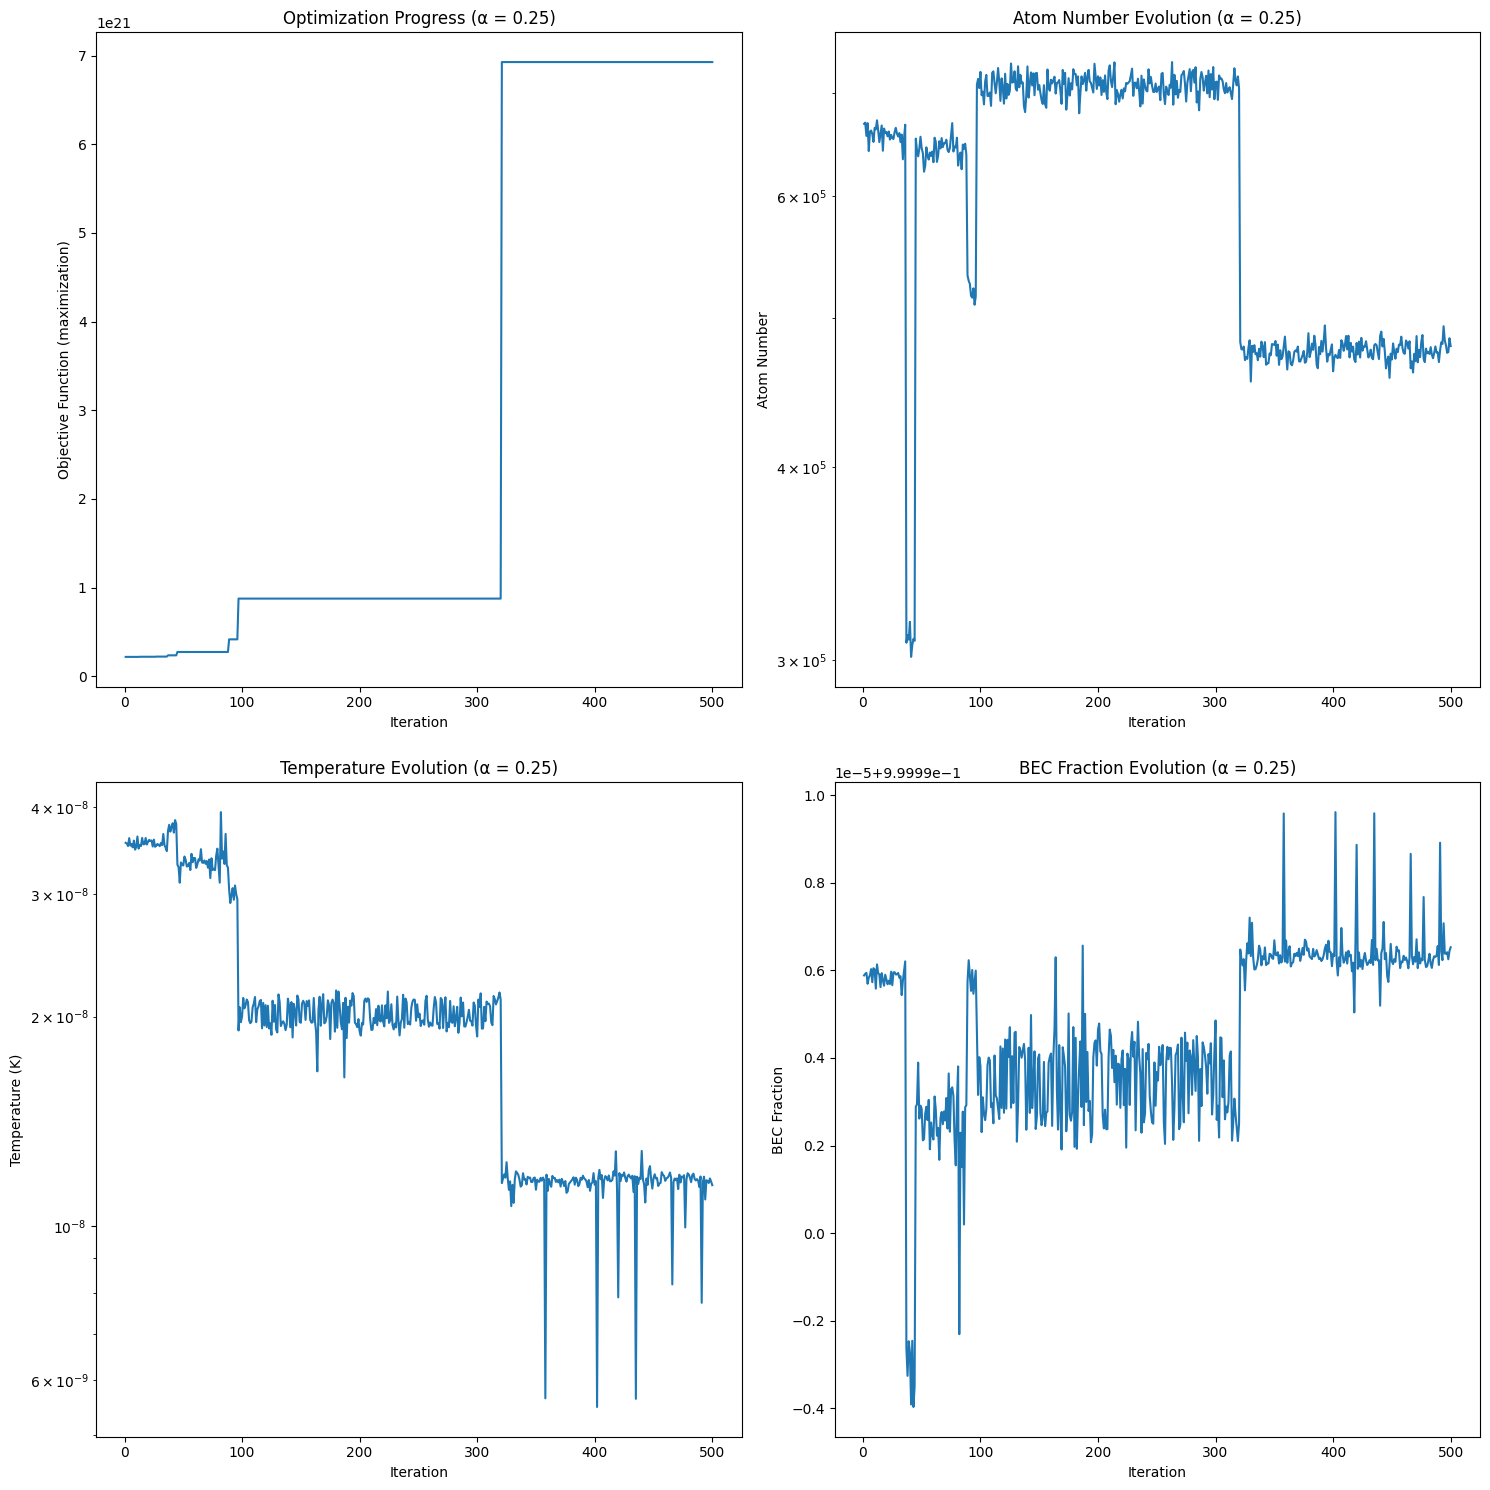

Plotting optimization images...


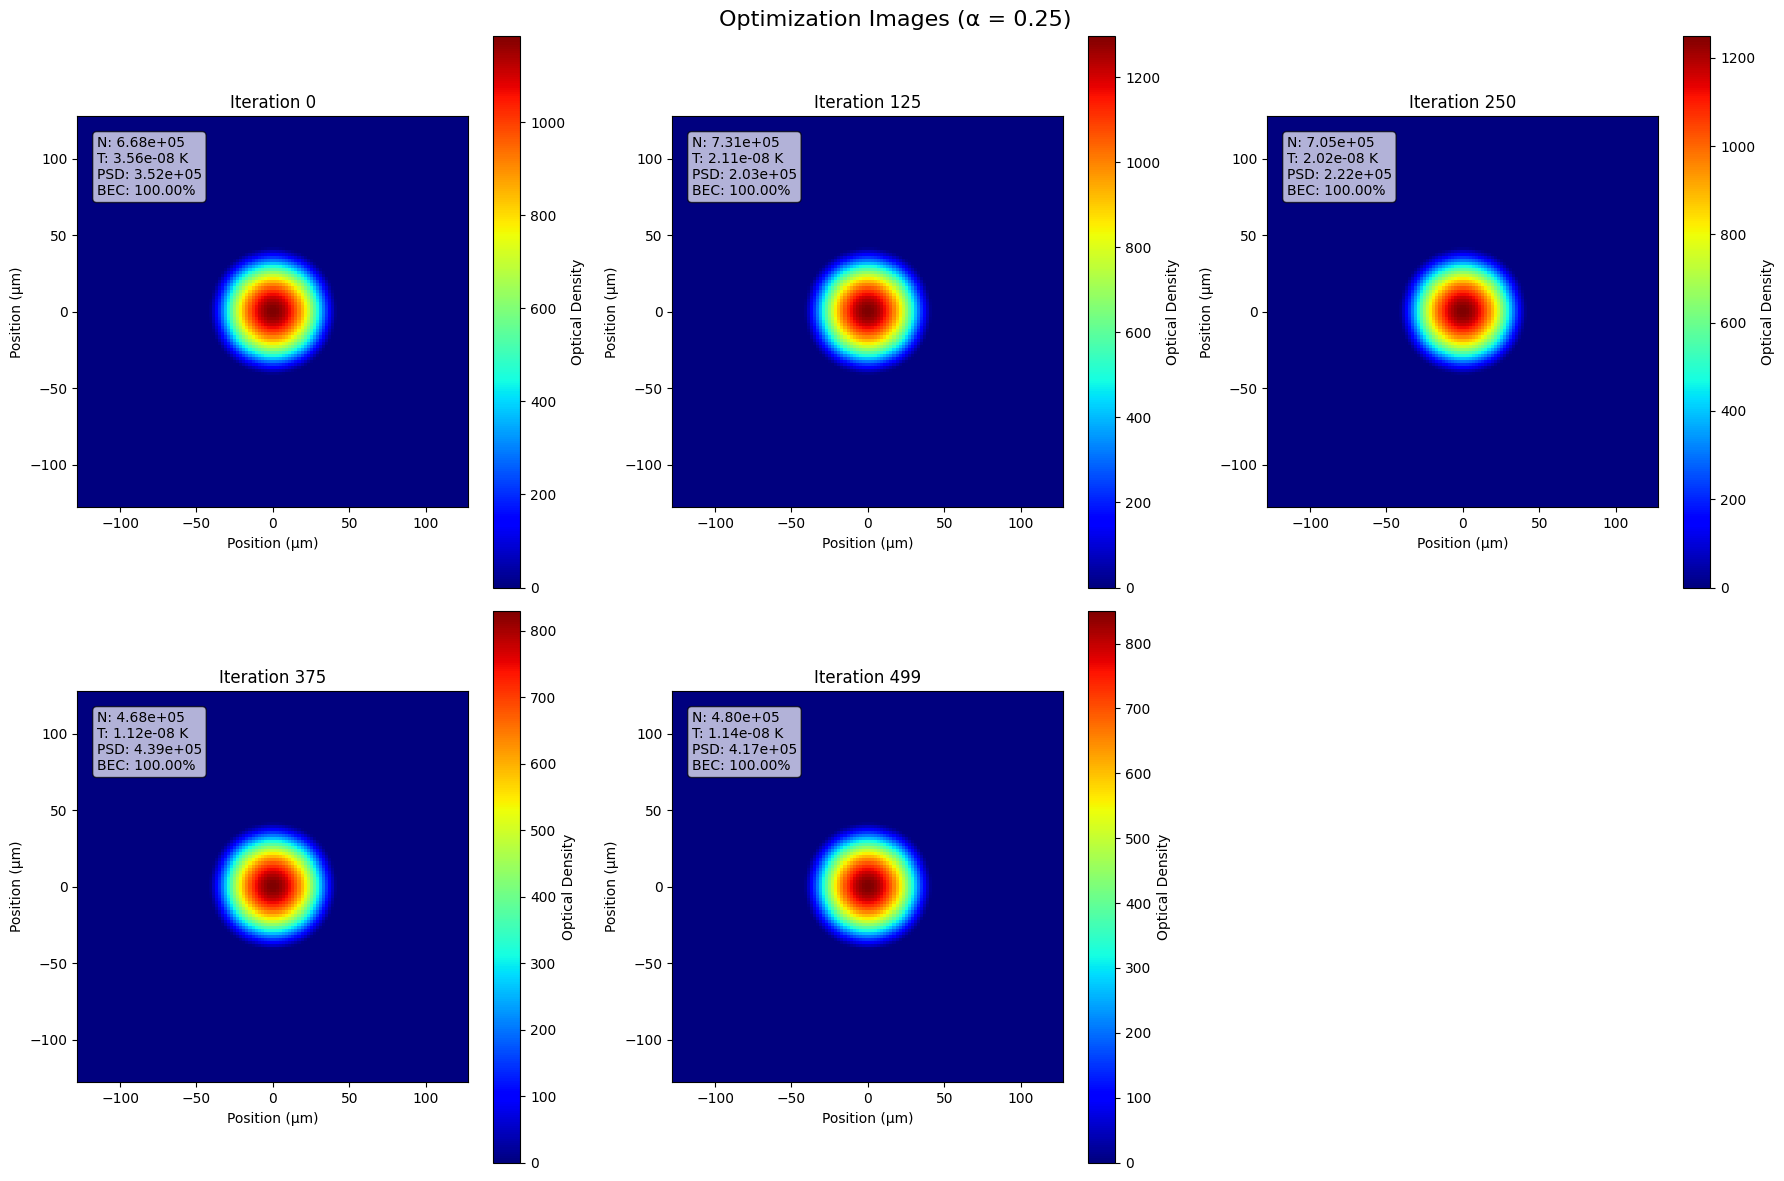

Running final simulation...


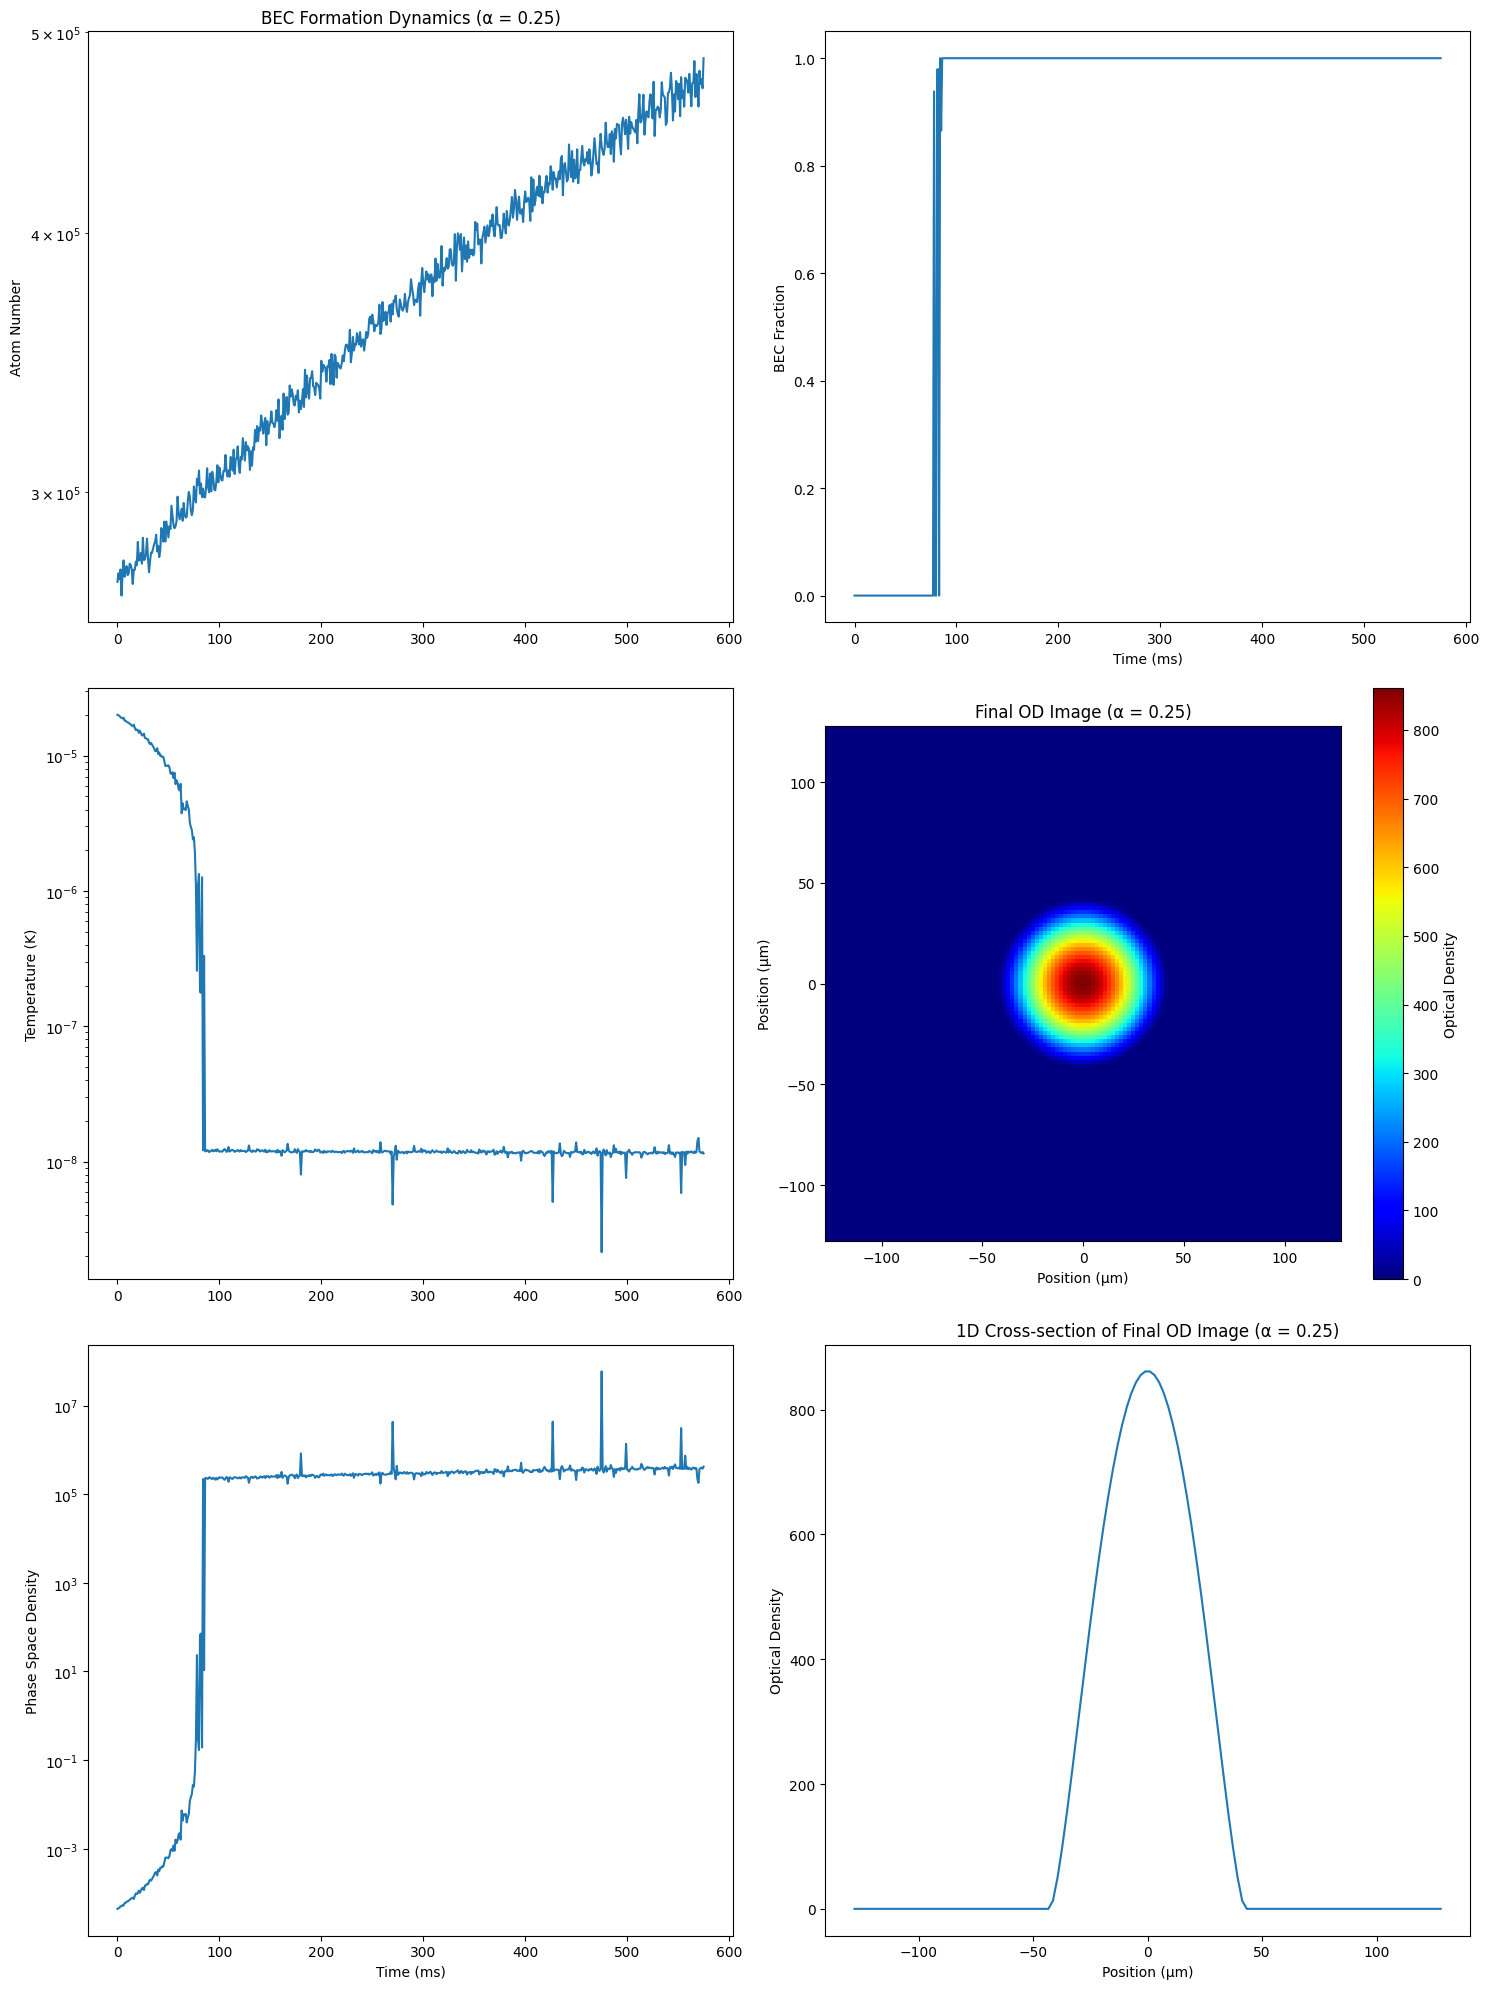

Final atom number: 4.86e+05
Final temperature: 1.15e-08 K
Final phase space density: 4.19e+05
Final BEC fraction: 100.00%

Optimized Parameters:
P_y: 2.1744e-02
P_z: 3.9362e-03
P_R: 2.0299e-03
P_p: 9.2971e-03
B_z: 8.7974e-04
trap_freq_x: 4.9345e+02
trap_freq_y: 9.9149e+01
trap_freq_z: 2.4104e+02
loading_rate: 3.5775e+05

Running optimization for alpha = 0.5
Optimizing parameters...
Running 0th iteration of Bayesian optimization (alpha=0.5)...
Running 1th iteration of Bayesian optimization (alpha=0.5)...
Running 2th iteration of Bayesian optimization (alpha=0.5)...
Running 3th iteration of Bayesian optimization (alpha=0.5)...
Running 4th iteration of Bayesian optimization (alpha=0.5)...
Running 5th iteration of Bayesian optimization (alpha=0.5)...
Running 6th iteration of Bayesian optimization (alpha=0.5)...
Running 7th iteration of Bayesian optimization (alpha=0.5)...
Running 8th iteration of Bayesian optimization (alpha=0.5)...
Running 9th iteration of Bayesian optimization (alpha=0.5

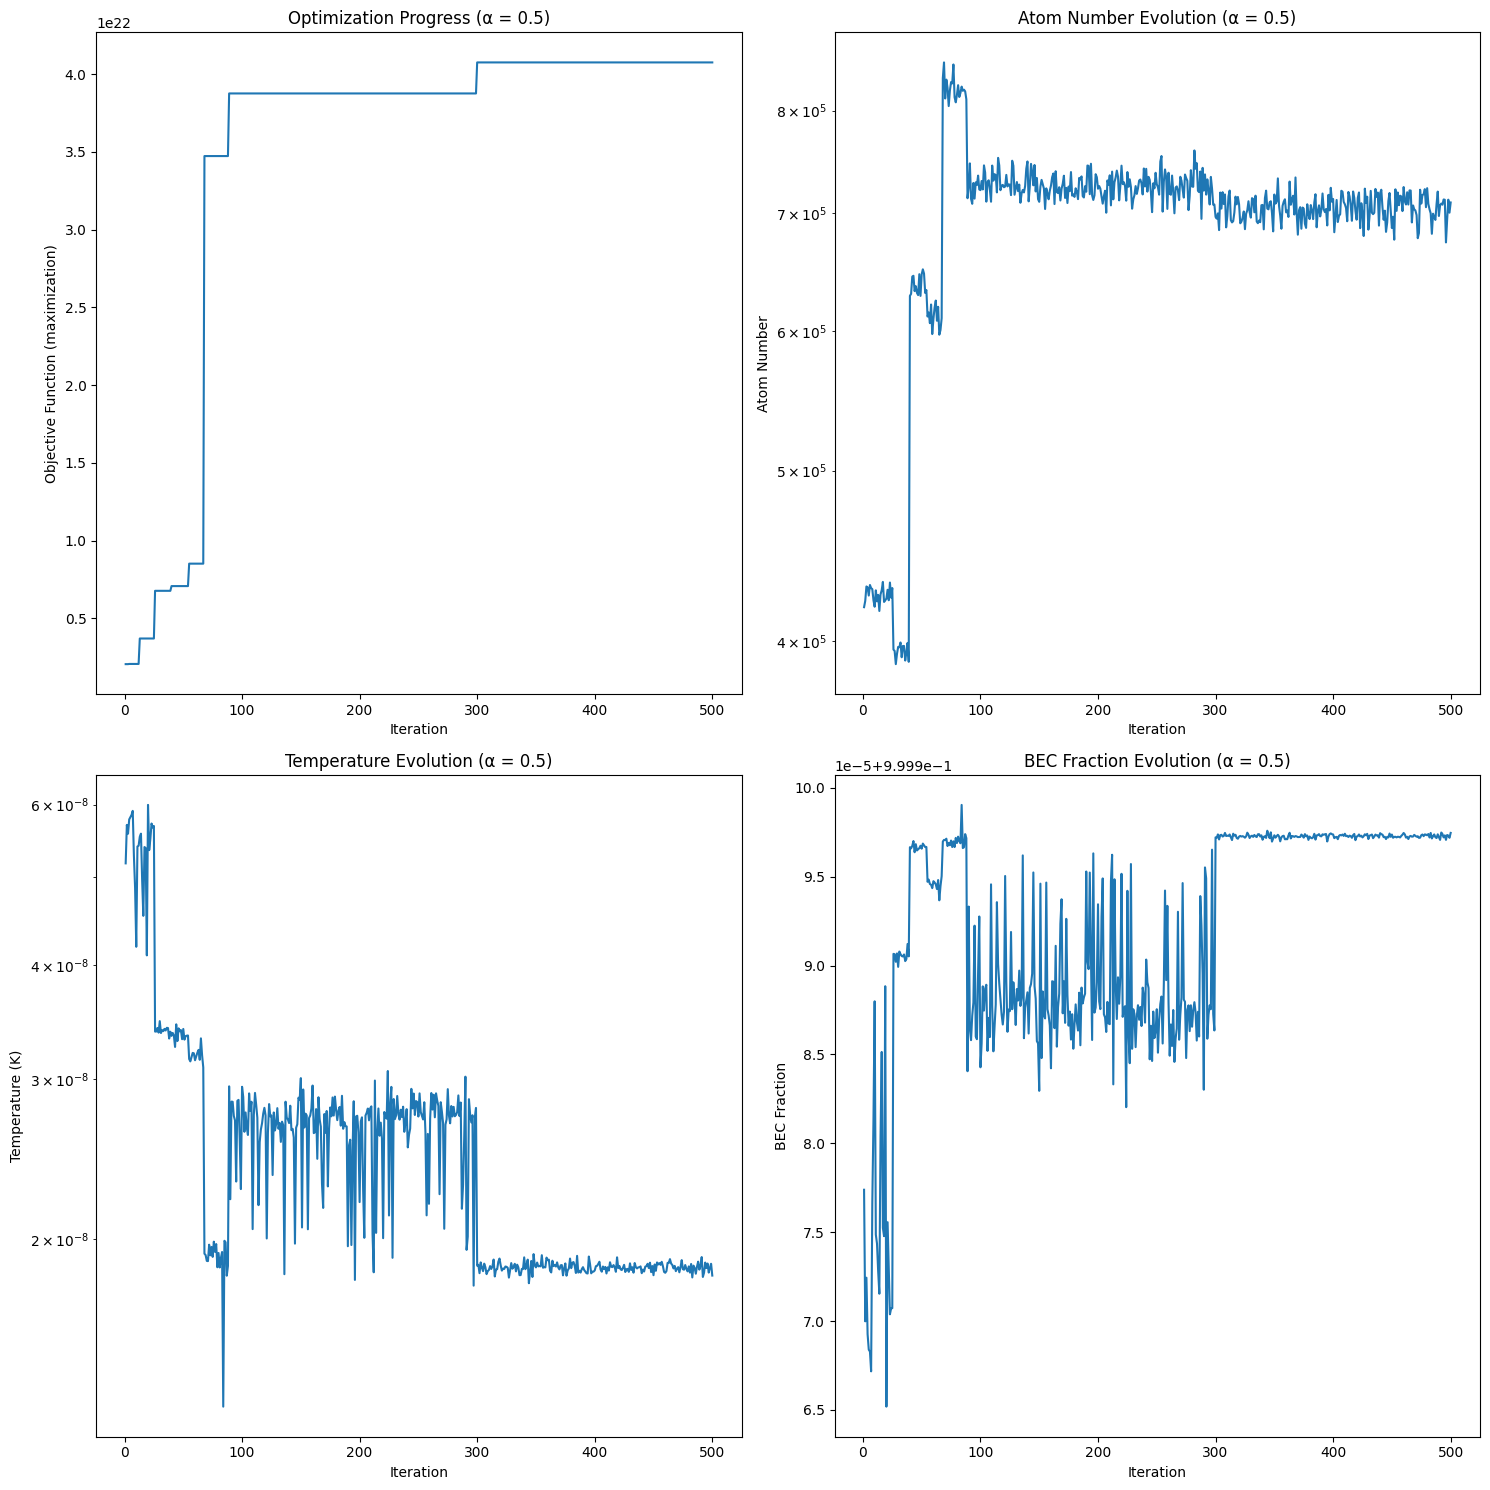

Plotting optimization images...


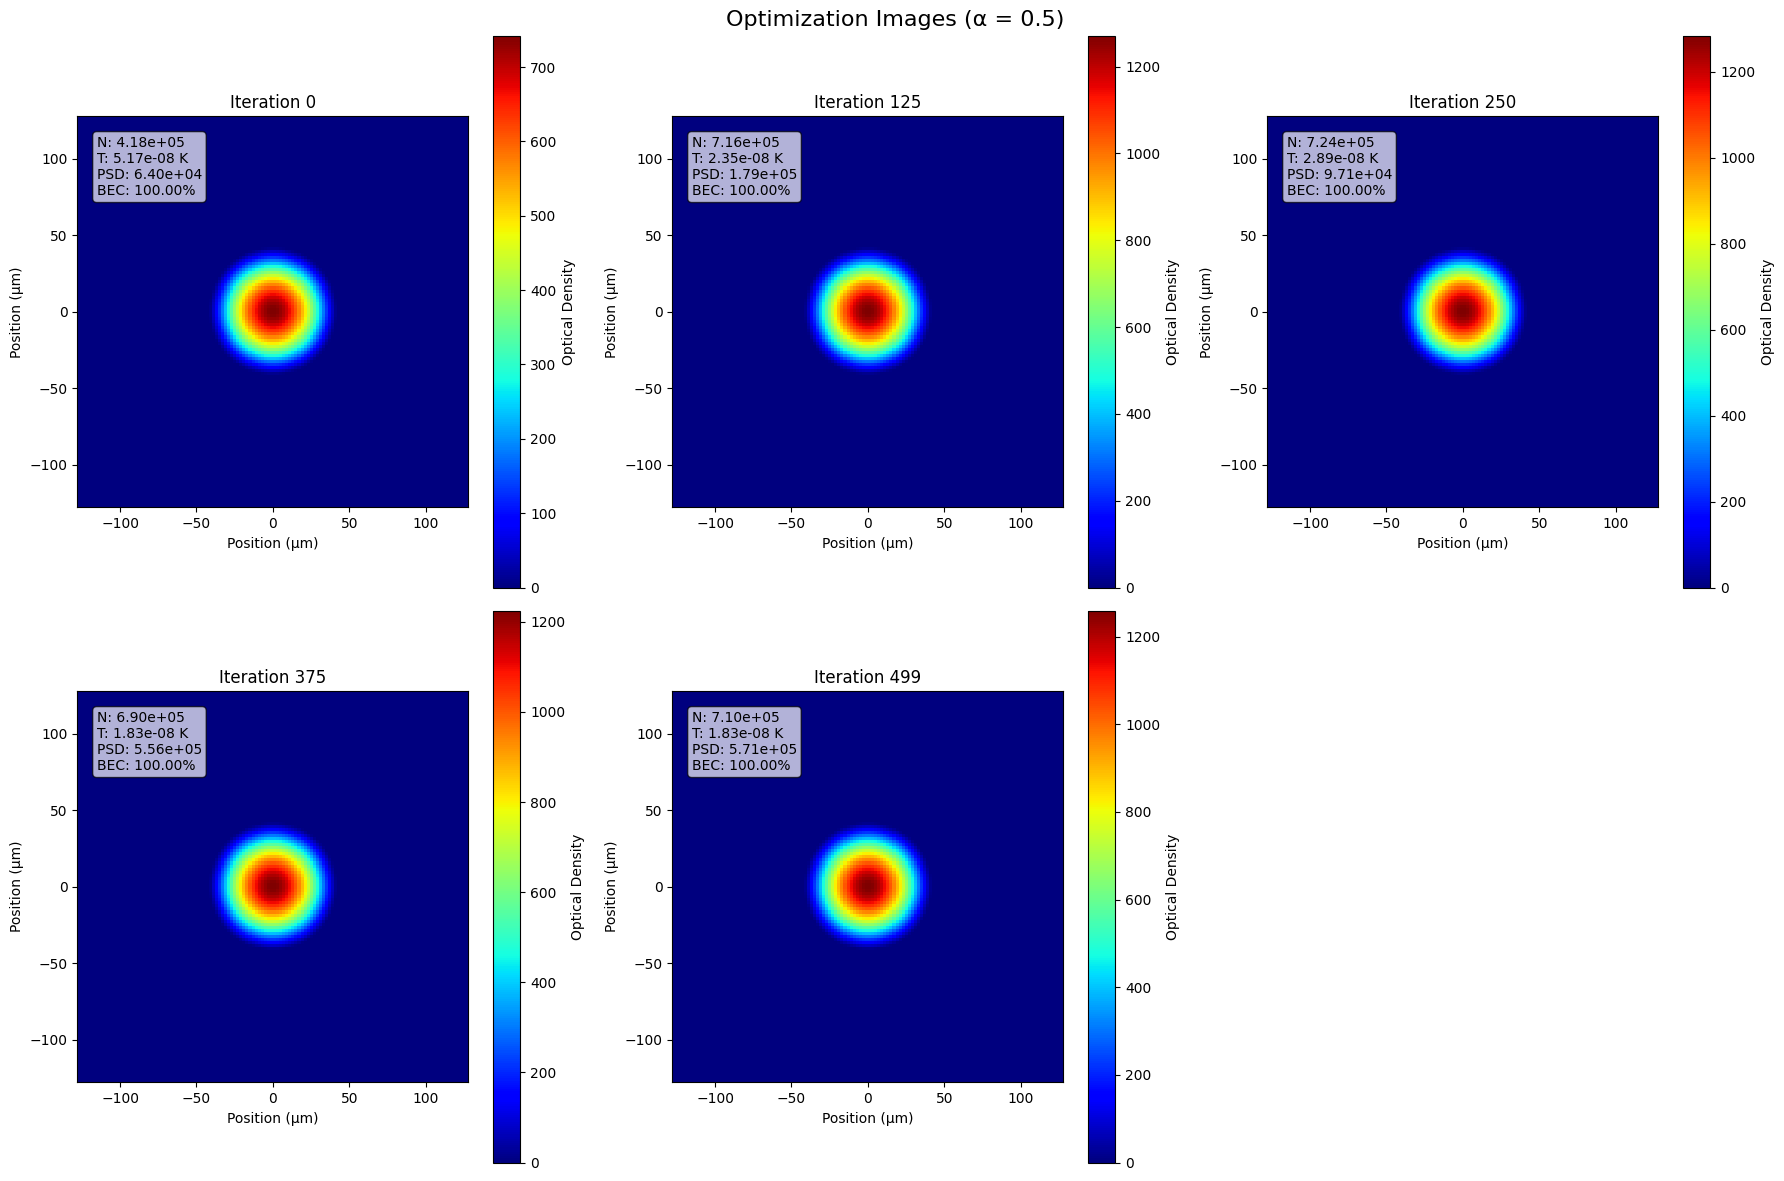

Running final simulation...


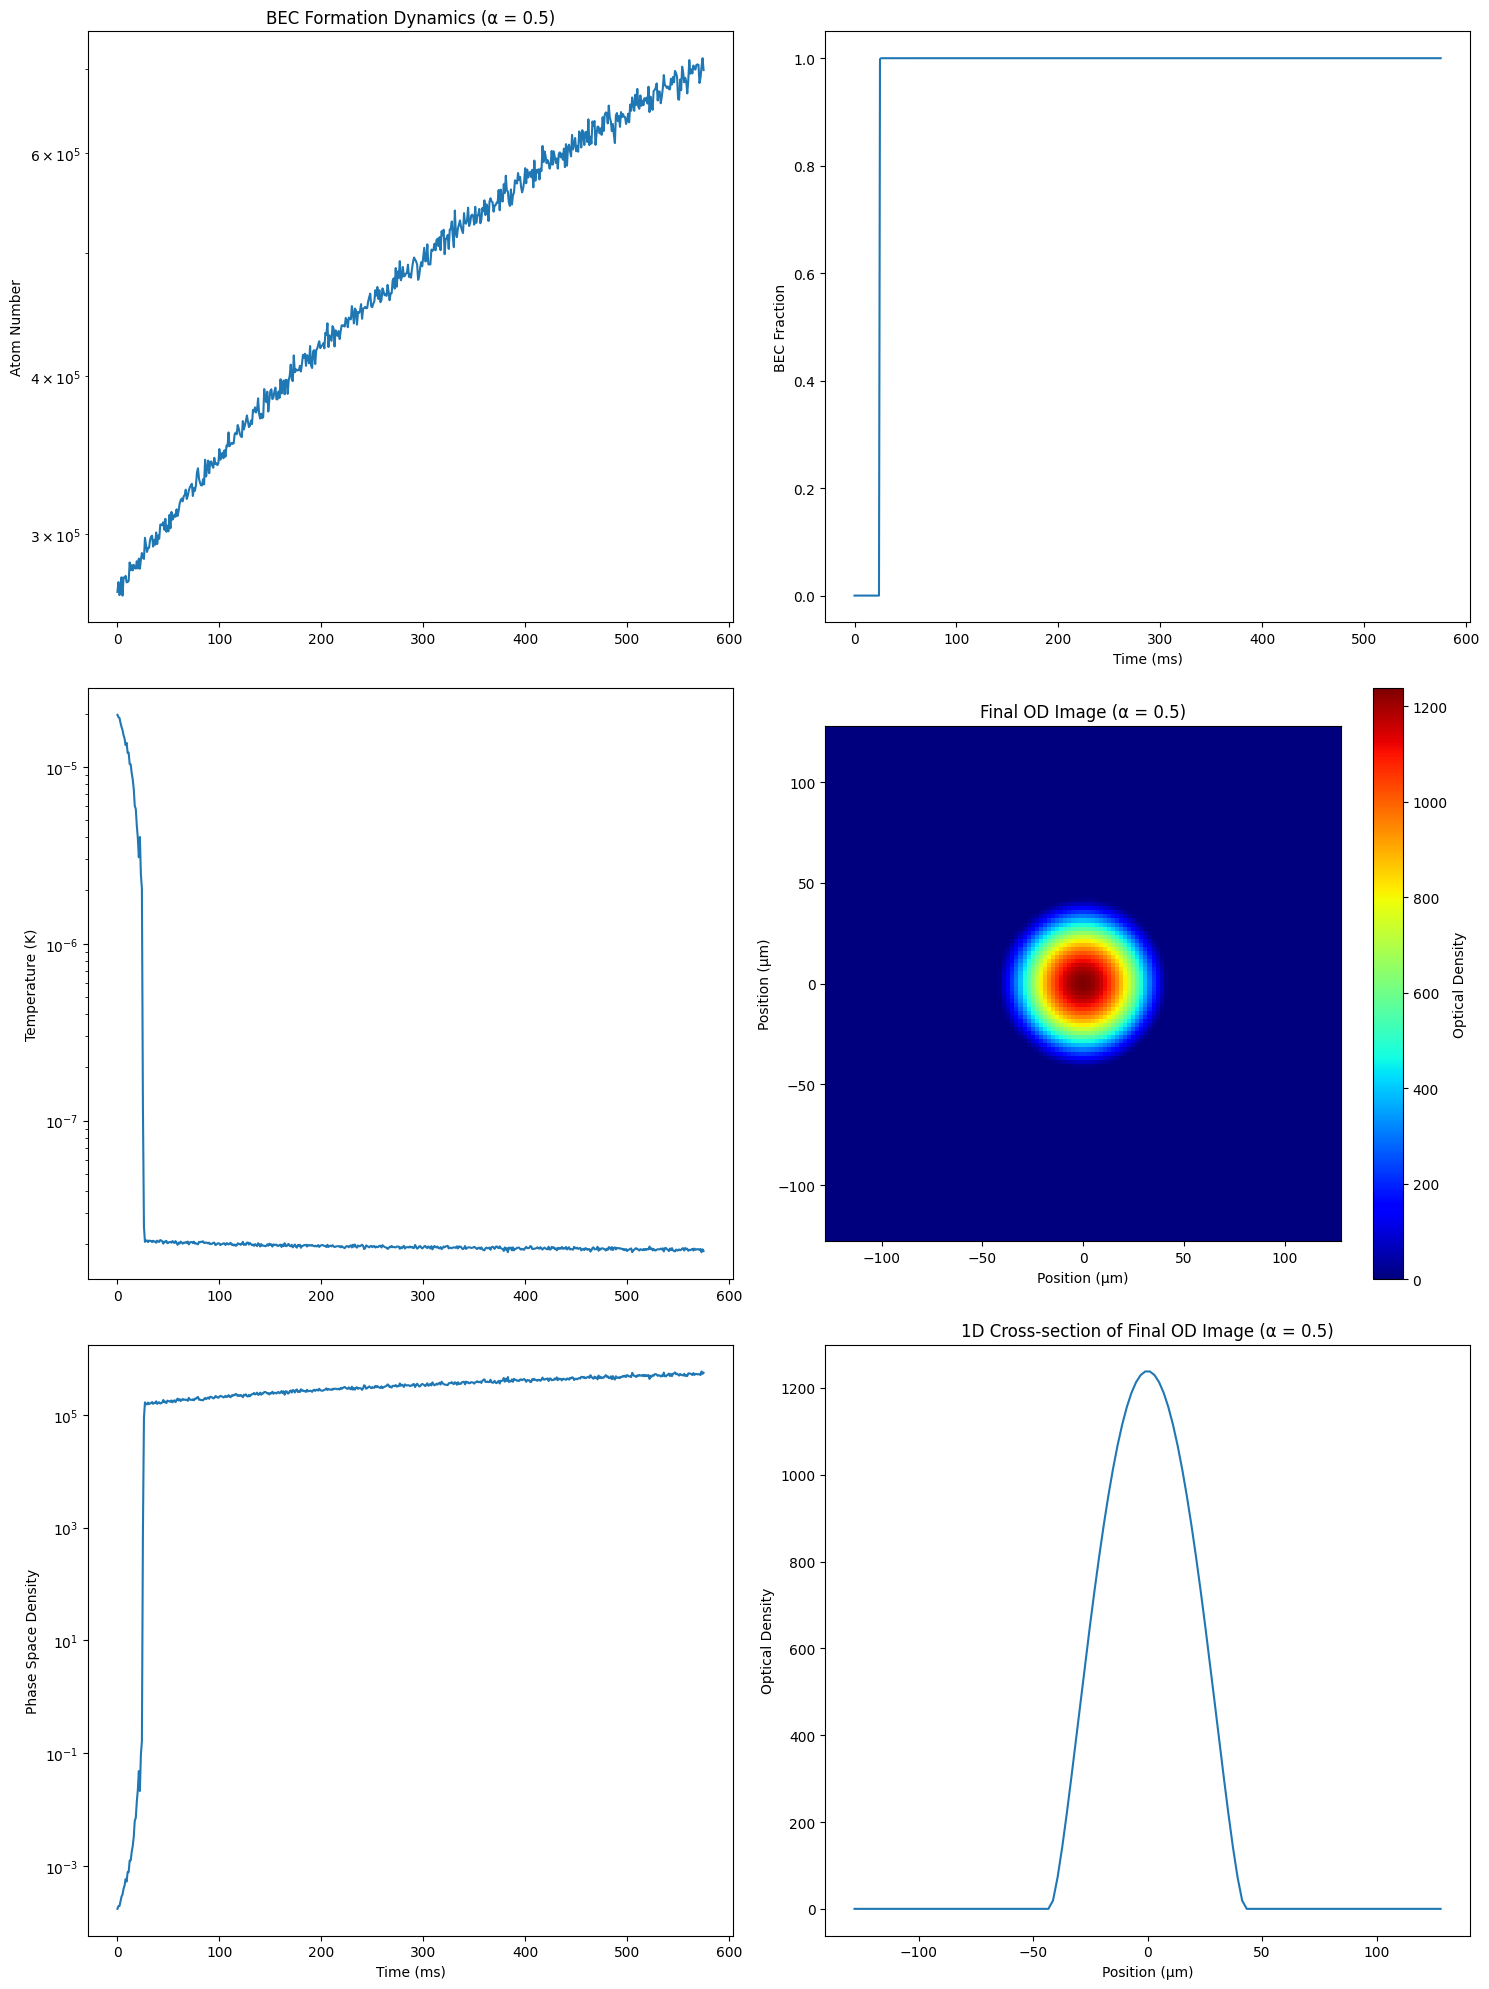

Final atom number: 6.98e+05
Final temperature: 1.84e-08 K
Final phase space density: 5.53e+05
Final BEC fraction: 100.00%

Optimized Parameters:
P_y: 6.5503e-02
P_z: 1.2555e-01
P_R: 6.8839e-03
P_p: 3.4222e-04
B_z: 1.0993e-04
trap_freq_x: 2.0297e+02
trap_freq_y: 3.6988e+02
trap_freq_z: 5.9036e+02
loading_rate: 7.5536e+05

Running optimization for alpha = 1.0
Optimizing parameters...
Running 0th iteration of Bayesian optimization (alpha=1.0)...
Running 1th iteration of Bayesian optimization (alpha=1.0)...
Running 2th iteration of Bayesian optimization (alpha=1.0)...
Running 3th iteration of Bayesian optimization (alpha=1.0)...
Running 4th iteration of Bayesian optimization (alpha=1.0)...
Running 5th iteration of Bayesian optimization (alpha=1.0)...
Running 6th iteration of Bayesian optimization (alpha=1.0)...
Running 7th iteration of Bayesian optimization (alpha=1.0)...
Running 8th iteration of Bayesian optimization (alpha=1.0)...
Running 9th iteration of Bayesian optimization (alpha=1.0

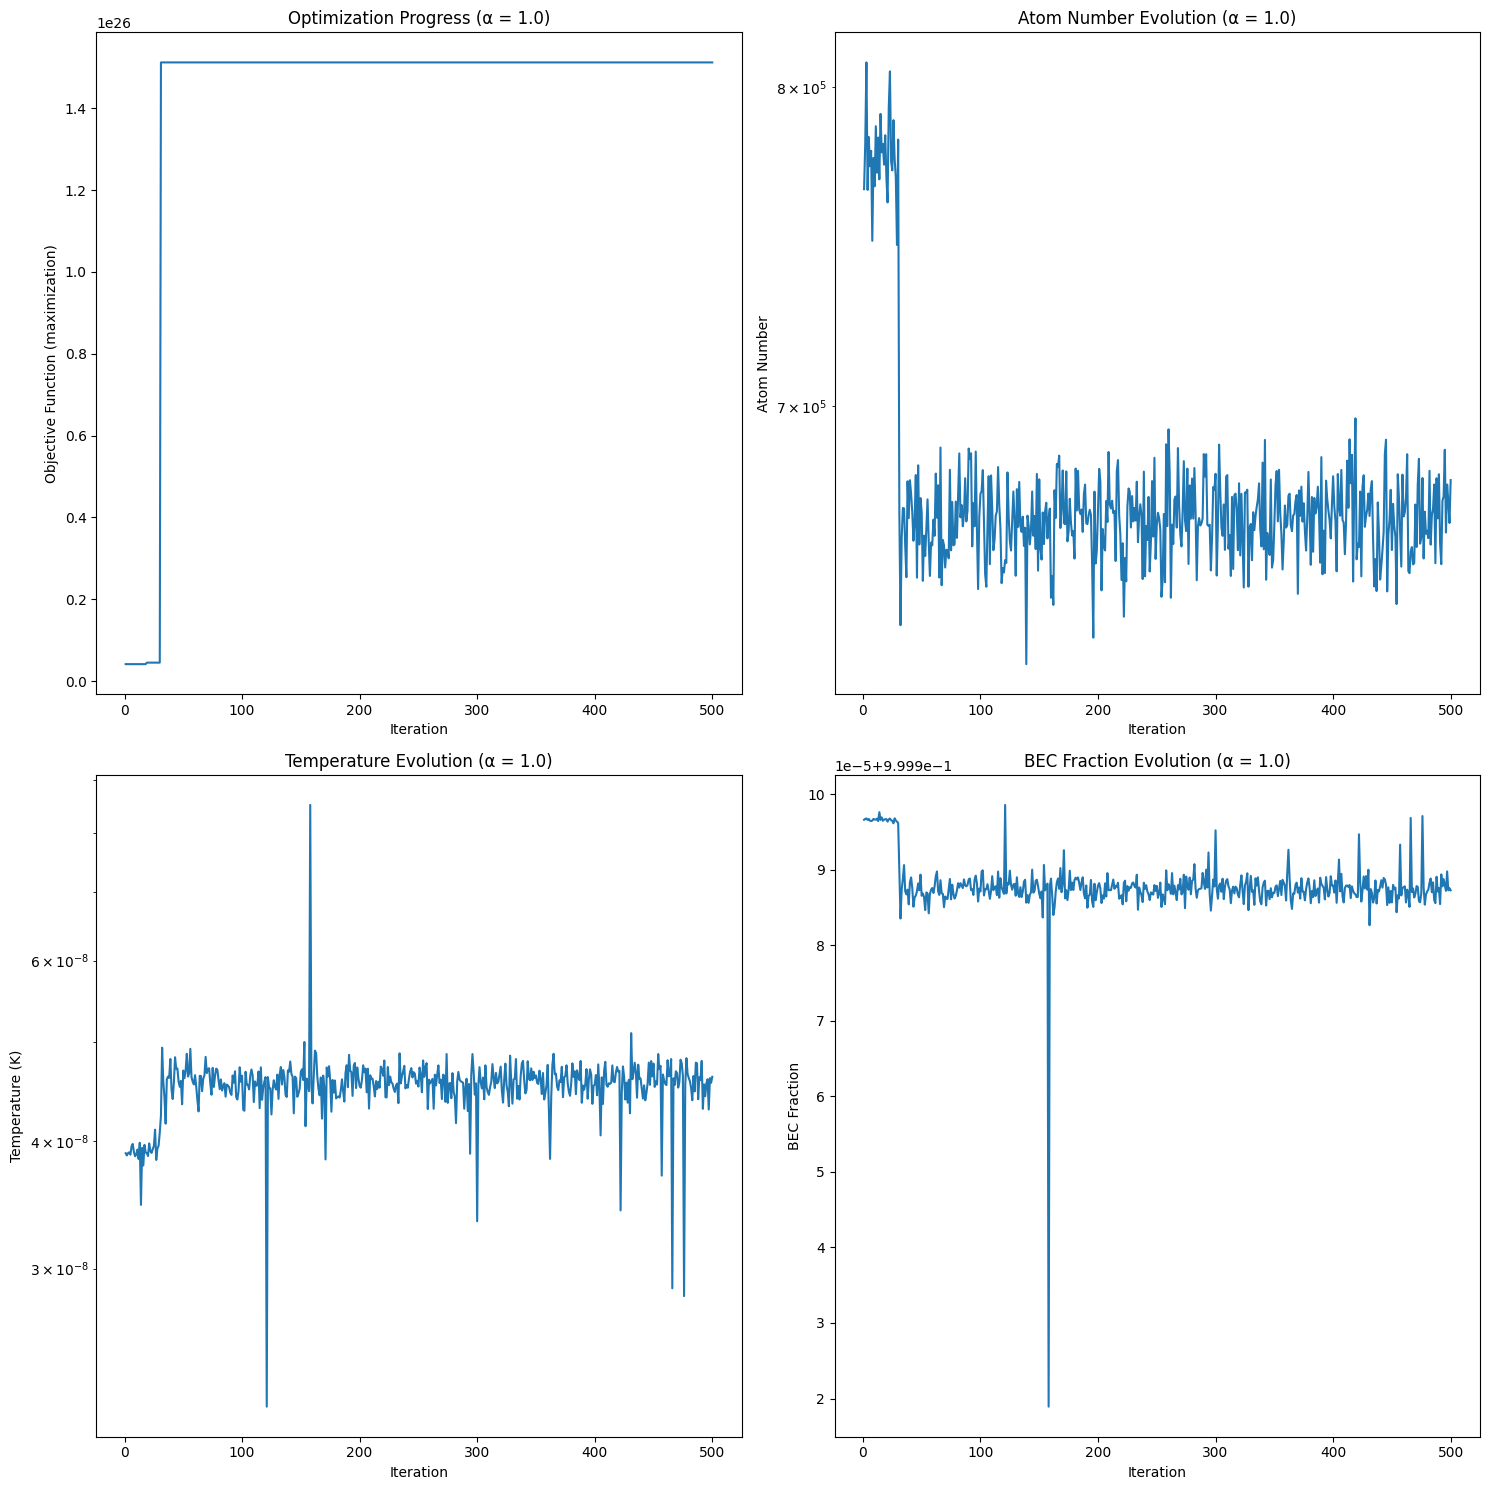

Plotting optimization images...


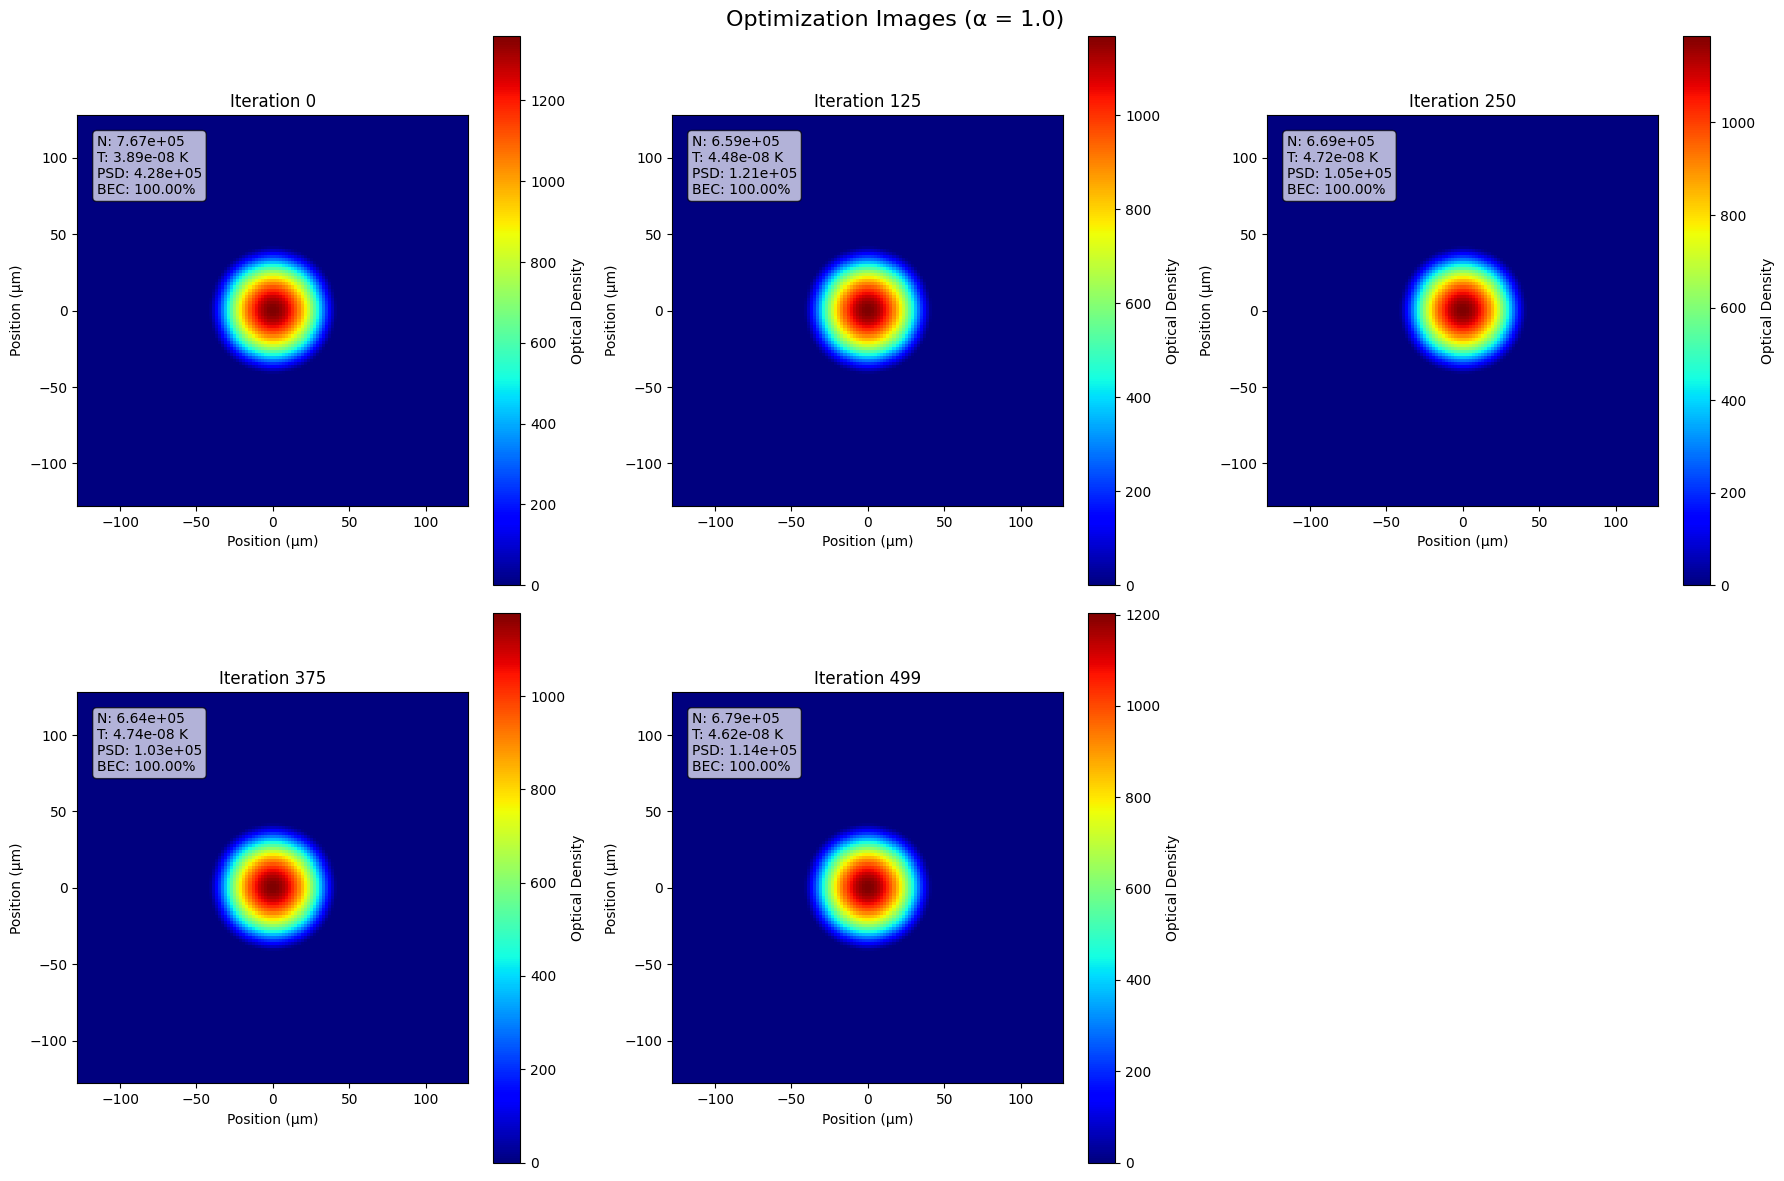

Running final simulation...


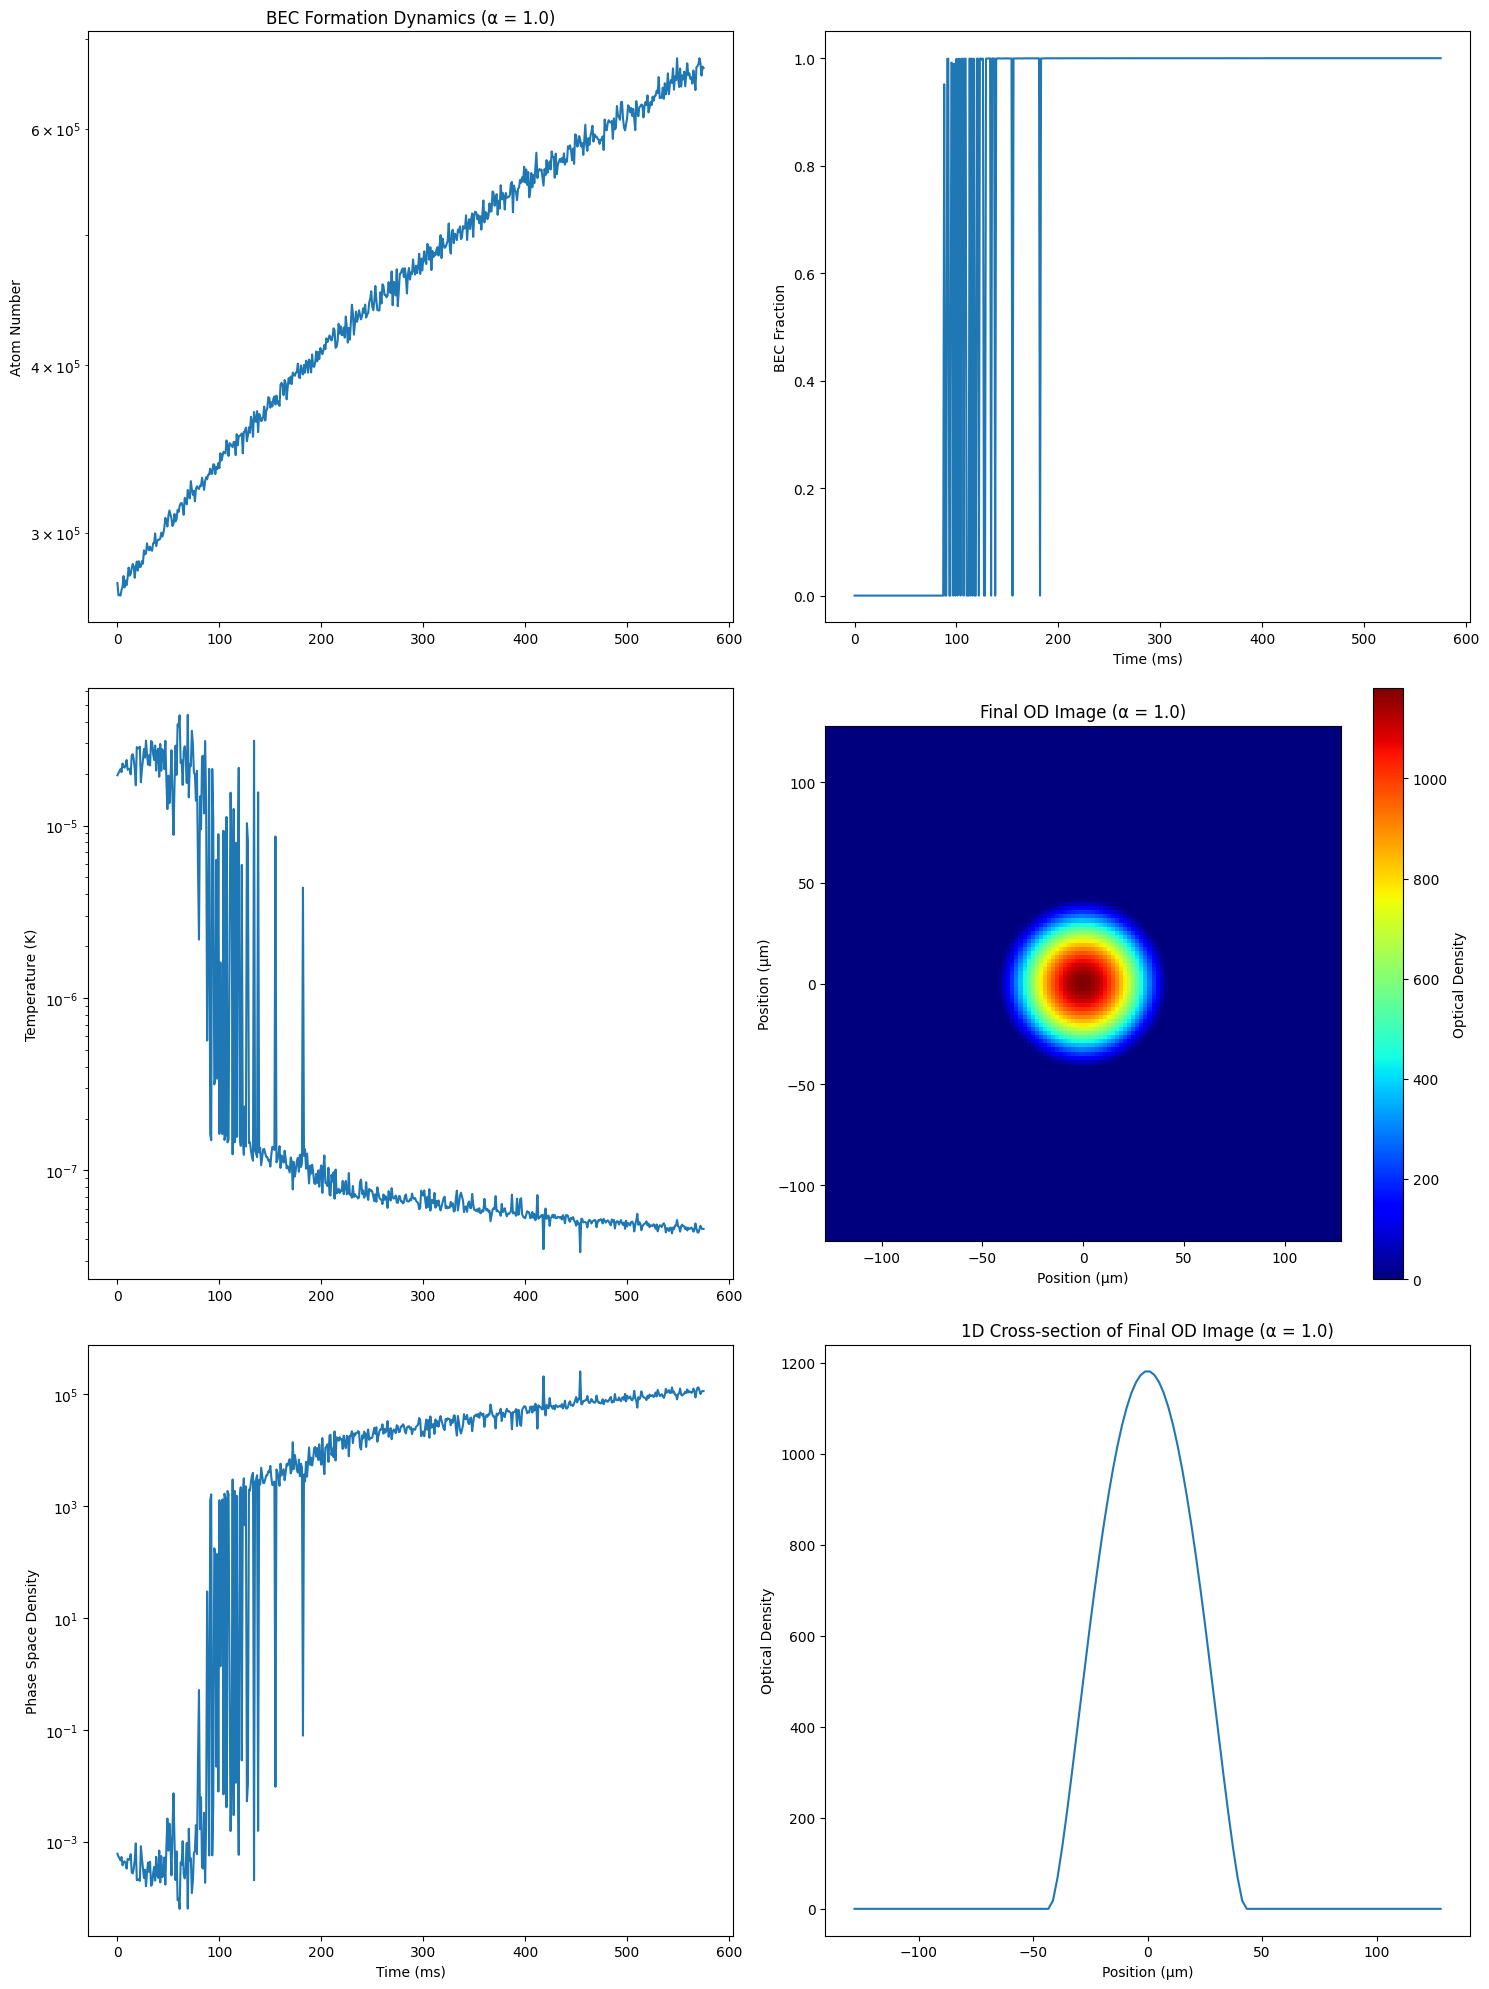

Final atom number: 6.66e+05
Final temperature: 4.58e-08 K
Final phase space density: 1.15e+05
Final BEC fraction: 100.00%

Optimized Parameters:
P_y: 1.3674e+00
P_z: 2.1467e+00
P_R: 5.0228e-03
P_p: 9.9019e-03
B_z: 7.7525e-04
trap_freq_x: 7.1078e+02
trap_freq_y: 3.0534e+02
trap_freq_z: 6.8866e+02
loading_rate: 6.9135e+05

Plotting OD comparison for different alpha values...


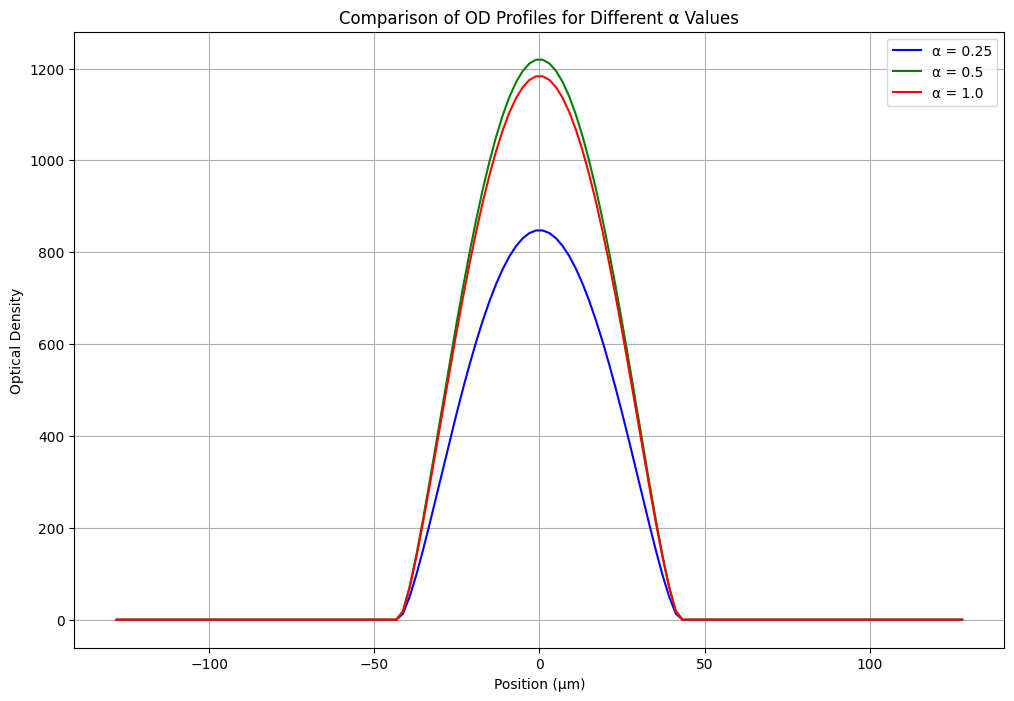

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.constants import h, k, atomic_mass, hbar
from scipy.integrate import odeint
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Constants
m = 87 * atomic_mass  # Mass of Rb-87
kb = k  # Boltzmann constant
a_s = 5.77e-9  # Scattering length for Rb-87 (m)
lambda_laser = 1064e-9  # Wavelength of trapping laser (m)

# Simulation parameters
N_initial = 2.7e5  # Initial number of atoms (from paper)
T_initial = 20e-6  # Initial temperature (K), estimate
time_step = 1e-3  # Time step for simulation (s)
total_time = 0.575  # Total simulation time (s), matching paper

# Noise parameters
hardware_noise_level = 0.02
environmental_noise_level = 0.01

# Define the parameter space for optimization
param_space = {
    'P_y': (1e-3, 3),  # Horizontal trap power (W)
    'P_z': (1e-3, 3),  # Vertical trap power (W)
    'P_R': (1e-6, 1e-2),  # Raman coupling power (W)
    'P_p': (1e-6, 1e-2),  # Optical pumping power (W)
    'B_z': (0, 1e-3),  # Magnetic field (T)
    'trap_freq_x': (1, 1e3),  # Trap frequency in x-direction (Hz)
    'trap_freq_y': (1, 1e3),  # Trap frequency in y-direction (Hz)
    'trap_freq_z': (1, 1e3),  # Trap frequency in z-direction (Hz)
    'loading_rate': (0, 1e6)  # Loading rate (atoms/s)
}

def safe_log(x):
    """Safely compute logarithm, avoiding domain errors."""
    return np.log(np.maximum(x, 1e-10))

def trap_potential(r, P_y, P_z, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the trapping potential."""
    w_x = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_x))
    w_y = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_y))
    w_z = np.sqrt(2 * hbar / (m * 2 * np.pi * trap_freq_z))
    
    return 0.5 * m * (
        (2 * np.pi * trap_freq_x)**2 * r[0]**2 +
        (2 * np.pi * trap_freq_y)**2 * r[1]**2 +
        (2 * np.pi * trap_freq_z)**2 * r[2]**2
    )

def raman_cooling_rate(v, P_R, P_p, B_z):
    """Calculate the Raman cooling rate."""
    v_r = hbar * 2 * np.pi / (m * lambda_laser)
    gamma_r = 2 * np.pi * 6.065e6
    delta = 2 * np.pi * 4.33e9
    
    return gamma_r * (P_R + P_p) / (1 + (2 * v / v_r)**2 + (2 * delta / gamma_r)**2) * np.exp(-v**2 / v_r**2)

def collision_rate(n, T):
    """Calculate the collision rate."""
    sigma = 8 * np.pi * a_s**2
    v_rms = np.sqrt(3 * kb * T / m)
    return n * sigma * v_rms

def bec_fraction(N, T, trap_freq_x, trap_freq_y, trap_freq_z):
    """Calculate the BEC fraction."""
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    T_c = 0.94 * hbar * omega_bar * (N / zeta(3))**(1/3) / kb
    return max(0, 1 - (T / T_c)**3) if T < T_c else 0

def zeta(x):
    """Riemann zeta function."""
    return np.sum(1 / np.arange(1, 1000)**x)

def system_dynamics(y, t, params):
    N, T = y
    P_y, P_z, P_R, P_p, B_z, trap_freq_x, trap_freq_y, trap_freq_z, loading_rate = params
    
    # Ensure positive values
    N = max(N, 1e-10)
    T = max(T, 1e-10)
    
    # Calculate trap properties
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
    n = N / V_eff
    
    # Calculate rates
    gamma_col = collision_rate(n, T)
    gamma_cool = raman_cooling_rate(np.sqrt(3 * kb * T / m), P_R, P_p, B_z)
    gamma_heat = 1e-3 * (P_y + P_z)
    gamma_loss = 1e-2 * np.exp(-safe_log(P_y + P_z) + safe_log(kb * T))
    
    # System dynamics
    dNdt = loading_rate - gamma_loss * N
    dTdt = gamma_heat - gamma_cool * T + (gamma_col / 3) * (hbar * omega_bar / kb - T)
    
    return [dNdt, dTdt]

def simulate_bec(params, t):
    try:
        # Add hardware noise
        params_with_noise = [max(p * (1 + np.random.normal(0, hardware_noise_level)), 1e-10) for p in params]
        
        # Solve ODE
        y0 = [N_initial, T_initial]
        solution = odeint(system_dynamics, y0, [0, t], args=(params_with_noise,))
        
        N, T = solution[-1]
        
        # Add environmental noise
        N = max(N * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        T = max(T * (1 + np.random.normal(0, environmental_noise_level)), 1e-10)
        
        # Calculate phase space density
        omega_bar = (params[5] * params[6] * params[7])**(1/3) * 2 * np.pi
        V_eff = (2 * np.pi * kb * T / (m * omega_bar**2))**(3/2)
        n = N / V_eff
        lambda_dB = h / np.sqrt(2 * np.pi * m * kb * T)
        PSD = n * lambda_dB**3
        
        # Calculate BEC fraction
        f_bec = bec_fraction(N, T, params[5], params[6], params[7])
        
        return N, T, PSD, f_bec
    except Exception as e:
        print(f"Error in simulate_bec: {e}")
        return 1e-10, 1e-10, 1e-10, 0

def objective_function(params, alpha):
    try:
        N, T, PSD, f_bec = simulate_bec(params, total_time)
        
        # Calculate optical depth (simplified model)
        OD = N**(2/5) / T
        
        # Cost function (to be minimized)
        cost = -(OD**3 * N**(alpha - 9/5))
        
        return cost if np.isfinite(cost) else 1e10
    except Exception as e:
        print(f"Error in objective_function: {e}")
        return 1e10

def generate_od_image(N, T, f_bec, trap_freq_x, trap_freq_y, trap_freq_z, image_size=128, tof=0.025):
    """Generate a simulated optical density (OD) image of the BEC and thermal cloud."""
    N_bec = N * f_bec
    N_thermal = N - N_bec
    
    # Calculate cloud sizes after time of flight
    omega_bar = (trap_freq_x * trap_freq_y * trap_freq_z)**(1/3) * 2 * np.pi
    R_tf = (15 * N_bec * a_s * hbar**2 / (m**2 * omega_bar**2))**(1/5)  # Thomas-Fermi radius
    sigma_thermal = np.sqrt(kb * T / (m * omega_bar**2))
    
    x = np.linspace(-3*R_tf, 3*R_tf, image_size)
    y = np.linspace(-3*R_tf, 3*R_tf, image_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    # BEC component (Thomas-Fermi profile)
    od_bec = np.maximum(0, (1 - (R / R_tf)**2))**(3/2)
    od_bec *= N_bec / np.sum(od_bec)  # Normalize
    
    # Thermal component (Gaussian profile)
    od_thermal = np.exp(-(X**2 + Y**2) / (2 * sigma_thermal**2))
    od_thermal *= N_thermal / np.sum(od_thermal)  # Normalize
    
    # Combine BEC and thermal components
    od_total = od_bec + od_thermal
    
    return od_total

def bayesian_optimization(n_iterations=100, n_images=5, alpha=0.5):
    def obj_wrapper(x):
        return objective_function(x.flatten(), alpha)
    
    bounds = np.array(list(param_space.values()))
    n_params = len(bounds)
    
    kernel = C(1.0, (1e-3, 1e3)) * RBF(np.ones(n_params), (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(10, n_params))
    y_sample = np.array([obj_wrapper(x) for x in X_sample])
    
    best_params = X_sample[np.argmin(y_sample)]
    best_images = []
    best_N_list = []
    best_T_list = []
    best_PSD_list = []
    best_f_bec_list = []
    
    all_costs = []
    all_N = []
    all_T = []
    all_f_bec = []
    
    image_indices = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1]
    
    for i in range(n_iterations):
        print(f"Running {i}th iteration of Bayesian optimization (alpha={alpha})...")
        try:
            gp.fit(X_sample, y_sample)
            
            def acquisition(x):
                mean, std = gp.predict(x.reshape(1, -1), return_std=True)
                return mean - 1.96 * std
            
            result = minimize(acquisition, X_sample[np.argmin(y_sample)], method='L-BFGS-B', bounds=bounds)
            
            if result.success:
                X_next = result.x
            else:
                X_next = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(1, n_params))
            
            y_next = obj_wrapper(X_next)
            
            X_sample = np.vstack((X_sample, X_next))
            y_sample = np.append(y_sample, y_next)
            
            best_cost = np.min(y_sample)
            best_params = X_sample[np.argmin(y_sample)]
            
            N, T, PSD, f_bec = simulate_bec(best_params, total_time)
            all_costs.append(-best_cost)
            all_N.append(N)
            all_T.append(T)
            all_f_bec.append(f_bec)
            
            if i in image_indices:
                od_image = generate_od_image(N, T, f_bec, best_params[5], best_params[6], best_params[7])
                best_images.append(od_image)
                best_N_list.append(N)
                best_T_list.append(T)
                best_PSD_list.append(PSD)
                best_f_bec_list.append(f_bec)
        
        except Exception as e:
            print(f"Error in iteration {i}: {e}")
            continue
    
    return best_params, best_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec

def plot_optimization_performance(all_costs, all_N, all_T, all_f_bec, alpha):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    iterations = range(1, len(all_costs) + 1)
    
    axs[0, 0].plot(iterations, all_costs)
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].set_ylabel('Objective Function (maximization)')
    axs[0, 0].set_title(f'Optimization Progress (α = {alpha})')
    
    axs[0, 1].semilogy(iterations, all_N)
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].set_ylabel('Atom Number')
    axs[0, 1].set_title(f'Atom Number Evolution (α = {alpha})')
    
    axs[1, 0].semilogy(iterations, all_T)
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].set_ylabel('Temperature (K)')
    axs[1, 0].set_title(f'Temperature Evolution (α = {alpha})')
    
    axs[1, 1].plot(iterations, all_f_bec)
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('BEC Fraction')
    axs[1, 1].set_title(f'BEC Fraction Evolution (α = {alpha})')
    
    plt.tight_layout()
    plt.show()

def plot_optimization_images(images, N_list, T_list, PSD_list, f_bec_list, n_iterations, alpha):
    n_images = len(images)
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.ravel()
    
    for i, (image, N, T, PSD, f_bec) in enumerate(zip(images, N_list, T_list, PSD_list, f_bec_list)):
        if i < n_images:
            im = axs[i].imshow(image, cmap='jet', extent=[-128, 128, -128, 128])
            iteration = [0, n_iterations // 4, n_iterations // 2, 3 * n_iterations // 4, n_iterations - 1][i]
            axs[i].set_title(f"Iteration {iteration}")
            axs[i].set_xlabel('Position (μm)')
            axs[i].set_ylabel('Position (μm)')
            plt.colorbar(im, ax=axs[i], label='Optical Density')
            
            axs[i].text(0.05, 0.95, f"N: {N:.2e}\nT: {T:.2e} K\nPSD: {PSD:.2e}\nBEC: {f_bec:.2%}", 
                        transform=axs[i].transAxes, verticalalignment='top', 
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    for i in range(n_images, 6):
        fig.delaxes(axs[i])
    
    fig.suptitle(f'Optimization Images (α = {alpha})', fontsize=16)
    plt.tight_layout()
    plt.show()

def run_simulation(optimized_params):
    time_points = np.arange(0, total_time + time_step, time_step)
    N_values = []
    T_values = []
    PSD_values = []
    f_bec_values = []
    
    for t in time_points:
        N, T, PSD, f_bec = simulate_bec(optimized_params, t)
        N_values.append(N)
        T_values.append(T)
        PSD_values.append(PSD)
        f_bec_values.append(f_bec)
    
    return time_points, N_values, T_values, PSD_values, f_bec_values

def plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params, alpha):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    
    axs[0, 0].semilogy(time_points * 1e3, N_values)
    axs[0, 0].set_ylabel('Atom Number')
    axs[0, 0].set_title(f'BEC Formation Dynamics (α = {alpha})')
    
    axs[1, 0].semilogy(time_points * 1e3, T_values)
    axs[1, 0].set_ylabel('Temperature (K)')
    
    axs[2, 0].semilogy(time_points * 1e3, PSD_values)
    axs[2, 0].set_ylabel('Phase Space Density')
    axs[2, 0].set_xlabel('Time (ms)')
    
    axs[0, 1].plot(time_points * 1e3, f_bec_values)
    axs[0, 1].set_ylabel('BEC Fraction')
    axs[0, 1].set_xlabel('Time (ms)')
    
    N_final, T_final = N_values[-1], T_values[-1]
    f_bec_final = f_bec_values[-1]
    trap_freq_x, trap_freq_y, trap_freq_z = optimized_params[5:8]
    
    od_image = generate_od_image(N_final, T_final, f_bec_final, trap_freq_x, trap_freq_y, trap_freq_z)
    im = axs[1, 1].imshow(od_image, cmap='jet', extent=[-128, 128, -128, 128])
    axs[1, 1].set_title(f'Final OD Image (α = {alpha})')
    axs[1, 1].set_xlabel('Position (μm)')
    axs[1, 1].set_ylabel('Position (μm)')
    plt.colorbar(im, ax=axs[1, 1], label='Optical Density')
    
    center_row = od_image[od_image.shape[0]//2, :]
    axs[2, 1].plot(np.linspace(-128, 128, len(center_row)), center_row)
    axs[2, 1].set_title(f'1D Cross-section of Final OD Image (α = {alpha})')
    axs[2, 1].set_xlabel('Position (μm)')
    axs[2, 1].set_ylabel('Optical Density')
    
    plt.tight_layout()
    plt.show()

def plot_od_comparison(all_results):
    plt.figure(figsize=(12, 8))
    
    colors = ['b', 'g', 'r']  # Colors for different alpha values
    for (alpha, results), color in zip(all_results.items(), colors):
        params = results['params']
        N, T, _, f_bec = simulate_bec(params, total_time)
        trap_freq_x, trap_freq_y, trap_freq_z = params[5:8]
        
        od_image = generate_od_image(N, T, f_bec, trap_freq_x, trap_freq_y, trap_freq_z)
        center_row = od_image[od_image.shape[0]//2, :]
        
        plt.plot(np.linspace(-128, 128, len(center_row)), center_row, color=color, label=f'α = {alpha}')
    
    plt.title('Comparison of OD Profiles for Different α Values')
    plt.xlabel('Position (μm)')
    plt.ylabel('Optical Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
if __name__ == "__main__":
    alphas = [0.25, 0.5, 1.0]
    n_iterations = 500  # Reduced for demonstration, increase for better results
    n_images = 5
    
    all_results = {}
    
    for alpha in alphas:
        print(f"\nRunning optimization for alpha = {alpha}")
        
        # Run Bayesian optimization
        print("Optimizing parameters...")
        optimized_params, evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, all_costs, all_N, all_T, all_f_bec = bayesian_optimization(n_iterations=n_iterations, n_images=n_images, alpha=alpha)
        
        # Store results
        all_results[alpha] = {
            'params': optimized_params,
            'images': evolution_images,
            'N_list': best_N_list,
            'T_list': best_T_list,
            'PSD_list': best_PSD_list,
            'f_bec_list': best_f_bec_list,
            'costs': all_costs,
            'N': all_N,
            'T': all_T,
            'f_bec': all_f_bec
        }
        
        print("Optimization complete. Plotting optimization performance...")
        plot_optimization_performance(all_costs, all_N, all_T, all_f_bec, alpha)
        
        print("Plotting optimization images...")
        plot_optimization_images(evolution_images, best_N_list, best_T_list, best_PSD_list, best_f_bec_list, n_iterations, alpha)
        
        print("Running final simulation...")
        time_points, N_values, T_values, PSD_values, f_bec_values = run_simulation(optimized_params)
        plot_final_results(time_points, N_values, T_values, PSD_values, f_bec_values, optimized_params, alpha)

        print(f"Final atom number: {N_values[-1]:.2e}")
        print(f"Final temperature: {T_values[-1]:.2e} K")
        print(f"Final phase space density: {PSD_values[-1]:.2e}")
        print(f"Final BEC fraction: {f_bec_values[-1]:.2%}")

        # Print optimized parameters
        param_names = list(param_space.keys())
        print("\nOptimized Parameters:")
        for name, value in zip(param_names, optimized_params):
            print(f"{name}: {value:.4e}")
    
    # After generating all previous plots for each alpha, create the comparison plot
    print("\nPlotting OD comparison for different alpha values...")
    plot_od_comparison(all_results)